In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, roc_curve, f1_score,
    precision_score, recall_score
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

import shap

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

All libraries imported successfully!
Pandas: 2.2.2
NumPy: 2.0.2


In [ ]:
TRANSACTIONS_PATH = "транзакции в Мобильном интернет Банкинге.csv"
PATTERNS_PATH = "поведенческие паттерны клиентов.csv"

df_transactions = pd.read_csv(TRANSACTIONS_PATH, sep=';')
df_patterns = pd.read_csv(PATTERNS_PATH, sep=';')

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nTransactions shape: {df_transactions.shape}")
print(f"Patterns shape: {df_patterns.shape}")

def clean_datetime(col):
    return pd.to_datetime(col.str.strip("'"), errors='coerce')

df_transactions['transdate'] = clean_datetime(df_transactions['transdate'])
df_transactions['transdatetime'] = clean_datetime(df_transactions['transdatetime'])

df_patterns['transdate'] = clean_datetime(df_patterns['transdate'])

print("\nDatetime columns parsed successfully!")
print(f"\nTransaction date range: {df_transactions['transdatetime'].min()} to {df_transactions['transdatetime'].max()}")

DATASET OVERVIEW

Transactions shape: (13113, 7)
Patterns shape: (8587, 19)

Datetime columns parsed successfully!

Transaction date range: 2024-11-30 05:45:05 to 2025-08-29 22:12:01


In [ ]:
print("\n" + "=" * 60)
print("TRANSACTIONS SAMPLE")
print("=" * 60)
display(df_transactions.head(3))

print("\n" + "=" * 60)
print("PATTERNS SAMPLE")
print("=" * 60)
display(df_patterns.head(3))

print("\n" + "=" * 60)
print("DATA TYPES")
print("=" * 60)
print("\nTransactions dtypes:")
print(df_transactions.dtypes)
print("\nPatterns dtypes:")
print(df_patterns.dtypes)


TRANSACTIONS SAMPLE


,cst_dim_id,transdate,transdatetime,amount,docno,direction,target
0,2937833270.0000,2025-01-05,2025-01-05 16:32:02,31000.0000,5343,8406e407421ec28bd5f445793ef64fd1,0
1,2096229005.0000,2025-03-04,2025-03-04 17:41:57,4000.0000,8442,b3a3d4a6006293195d998957d4f01e42,0
2,2937759666.0000,2025-06-20,2025-06-20 10:08:07,3000.0000,9540,22b84292f0ebce65ad0808342615a03b,0



PATTERNS SAMPLE


,transdate,cst_dim_id,monthly_os_changes,monthly_phone_model_changes,last_phone_model_categorical,last_os_categorical,logins_last_7_days,logins_last_30_days,login_frequency_7d,login_frequency_30d,freq_change_7d_vs_mean,logins_7d_over_30d_ratio,avg_login_interval_30d,std_login_interval_30d,var_login_interval_30d,ewm_login_interval_7d,burstiness_login_interval,fano_factor_login_interval,zscore_avg_login_interval_7d
0,2025-03-05,453024373.0000,2,2,Vivo V2116,Android/13,6,20,0.8571,0.6666666666666666,0.2857142857142857,0.3000,131460.0000,213919.4783,45761543200,23007.1644,0.2388,348102.4129,-0.2211
1,2025-05-19,498636442.0000,1,1,Xiaomi_m2006c3mg,Android/10,2,22,0.2857,0.7333333333333333,-0.6103896103896104,0.0909,101520.0000,82733.7264,6844869490.909091,178980.0000,-0.1020,67423.8524,0.9363
2,2025-08-04,2934905461.0000,1,1,"iPhone16,1",iOS/18.5,2,2,0.2857,0.06666666666666667,3.2857142857142856,1.0000,67800.0000,-1.0000,-1.0,67800.0000,-1.0000,-1.0000,-1.0000



DATA TYPES

Transactions dtypes:
cst_dim_id              float64
transdate        datetime64[ns]
transdatetime    datetime64[ns]
amount                  float64
docno                     int64
direction                object
target                    int64
dtype: object

Patterns dtypes:
transdate                       datetime64[ns]
cst_dim_id                             float64
monthly_os_changes                       int64
monthly_phone_model_changes              int64
last_phone_model_categorical            object
last_os_categorical                     object
logins_last_7_days                       int64
logins_last_30_days                      int64
login_frequency_7d                     float64
login_frequency_30d                     object
freq_change_7d_vs_mean                  object
logins_7d_over_30d_ratio               float64
avg_login_interval_30d                 float64
std_login_interval_30d                 float64
var_login_interval_30d                  object
ewm_l

In [ ]:
print("Performing LEFT JOIN: Transactions ← Patterns")
print(f"   Keys: ['cst_dim_id', 'transdate']")

df_transactions['transdate'] = pd.to_datetime(df_transactions['transdate']).dt.date
df_patterns['transdate'] = pd.to_datetime(df_patterns['transdate']).dt.date

df = df_transactions.merge(
    df_patterns,
    on=['cst_dim_id', 'transdate'],
    how='left',
    suffixes=('', '_pattern')
)

print(f"\nMerge completed!")
print(f"   Shape before: {df_transactions.shape}")
print(f"   Shape after:  {df.shape}")

pattern_cols = [col for col in df_patterns.columns if col not in ['cst_dim_id', 'transdate']]
missing_patterns = df[pattern_cols[0]].isna().sum()
cold_start_pct = (missing_patterns / len(df)) * 100

print(f"\nCOLD START ANALYSIS:")
print(f"   Transactions without patterns: {missing_patterns:,} ({cold_start_pct:.2f}%)")
print(f"   These are new clients or logging gaps")

Performing LEFT JOIN: Transactions ← Patterns
   Keys: ['cst_dim_id', 'transdate']

Merge completed!
   Shape before: (13113, 7)
   Shape after:  (13140, 24)

COLD START ANALYSIS:
   Transactions without patterns: 378 (2.88%)
   These are new clients or logging gaps


In [ ]:
NUMERICAL_PATTERN_COLS = [
    'monthly_os_changes', 'monthly_phone_model_changes',
    'logins_last_7_days', 'logins_last_30_days',
    'login_frequency_7d', 'login_frequency_30d',
    'freq_change_7d_vs_mean', 'logins_7d_over_30d_ratio',
    'avg_login_interval_30d', 'std_login_interval_30d',
    'var_login_interval_30d', 'ewm_login_interval_7d',
    'burstiness_login_interval', 'fano_factor_login_interval',
    'zscore_avg_login_interval_7d'
]

CATEGORICAL_PATTERN_COLS = [
    'last_phone_model_categorical', 'last_os_categorical'
]

for col in NUMERICAL_PATTERN_COLS:
    if col in df.columns:
        df[col] = df[col].fillna(-1)

for col in CATEGORICAL_PATTERN_COLS:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

df['is_cold_start'] = (df['monthly_os_changes'] == -1).astype(int)

print("Cold Start Strategy Applied!")
print(f"   Cold Start Flag Distribution:")
print(df['is_cold_start'].value_counts())

print(f"\nMissing values after Cold Start handling:")
print(df.isnull().sum().sum())

Cold Start Strategy Applied!
   Cold Start Flag Distribution:
is_cold_start
0    12762
1      378
Name: count, dtype: int64

Missing values after Cold Start handling:
14


TARGET VARIABLE ANALYSIS

Class Distribution:
   Legit (0):  12,975 (98.74%)
   Fraud (1):  165 (1.26%)

Imbalance Ratio: 1:78


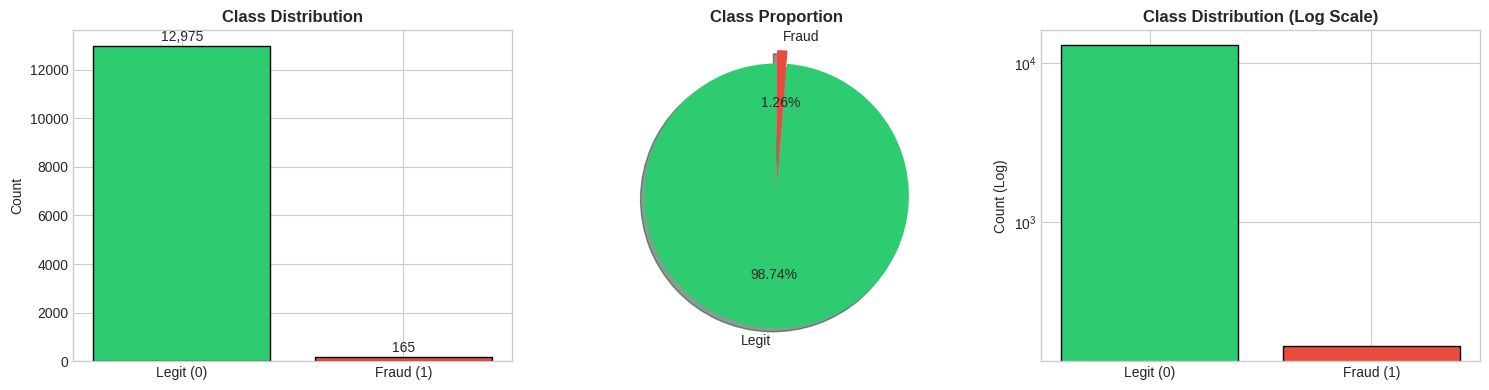

In [ ]:
print("=" * 60)
print("TARGET VARIABLE ANALYSIS")
print("=" * 60)

target_counts = df['target'].value_counts()
target_pct = df['target'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
print(f"   Legit (0):  {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"   Fraud (1):  {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: 1:{target_counts[0]//target_counts[1]}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axes[0]
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(['Legit (0)', 'Fraud (1)'], target_counts.values, color=colors, edgecolor='black')
ax1.set_title('Class Distribution', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count')
for bar, count in zip(bars, target_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{count:,}', ha='center', va='bottom', fontsize=10)

ax2 = axes[1]
ax2.pie(target_counts.values, labels=['Legit', 'Fraud'], colors=colors,
        autopct='%1.2f%%', explode=[0, 0.1], startangle=90, shadow=True)
ax2.set_title('Class Proportion', fontsize=12, fontweight='bold')

ax3 = axes[2]
ax3.bar(['Legit (0)', 'Fraud (1)'], target_counts.values, color=colors, edgecolor='black')
ax3.set_yscale('log')
ax3.set_title('Class Distribution (Log Scale)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Count (Log)')

plt.tight_layout()
plt.show()

TEMPORAL ANALYSIS OF FRAUD


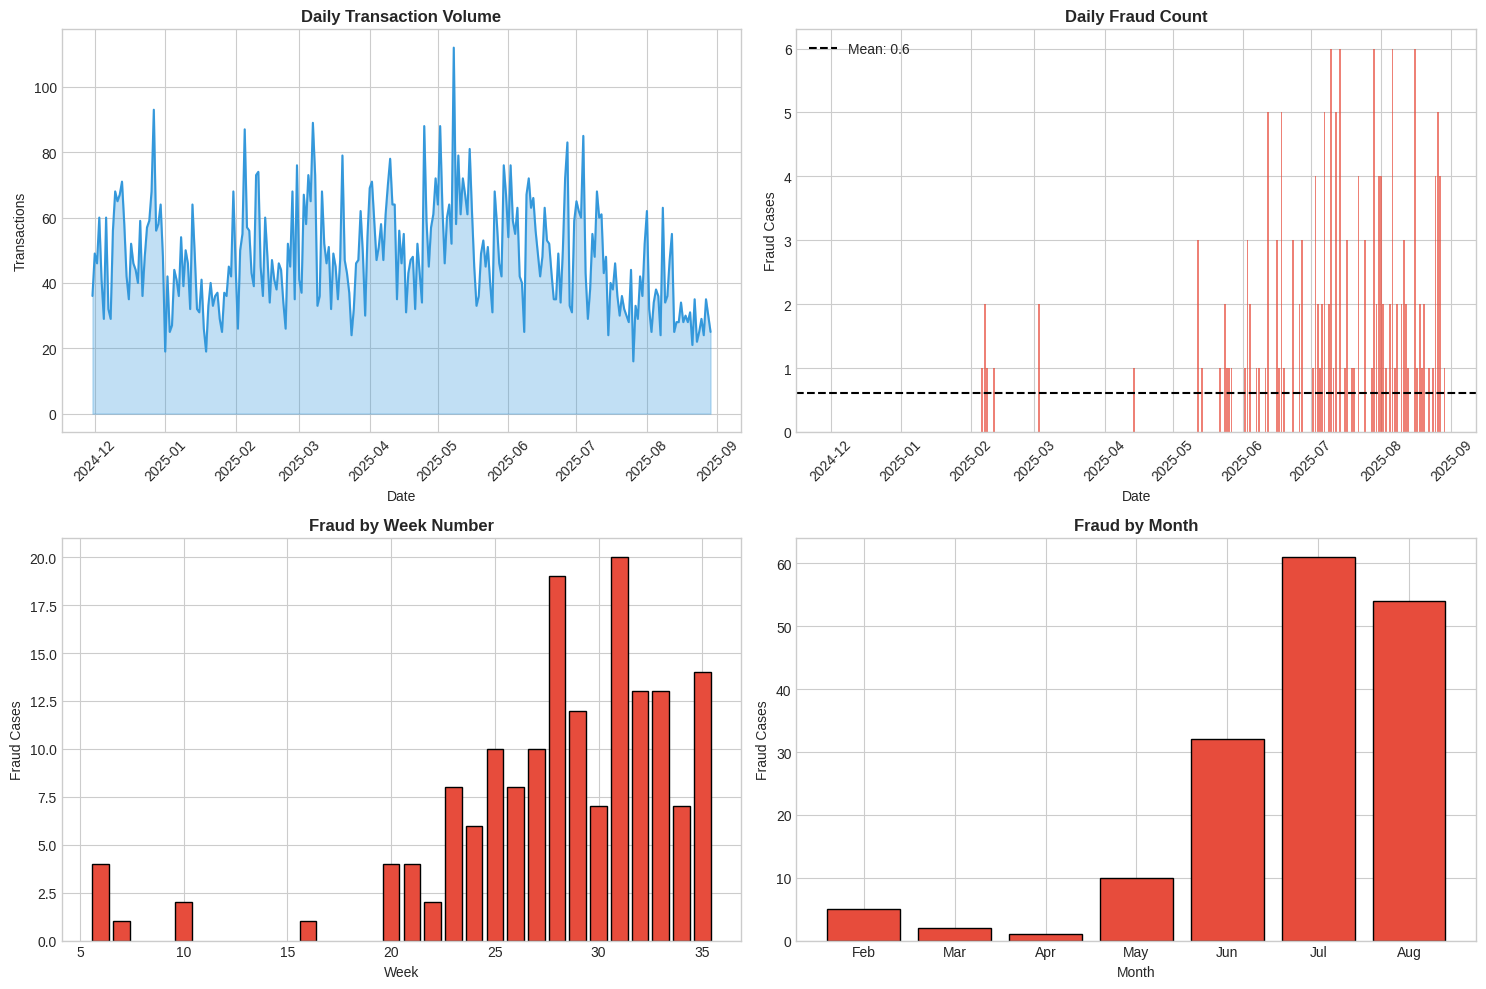

In [ ]:
print("=" * 60)
print("TEMPORAL ANALYSIS OF FRAUD")
print("=" * 60)

df['transdatetime'] = pd.to_datetime(df['transdatetime'])
df['trans_date'] = df['transdatetime'].dt.date

daily_fraud = df.groupby(['trans_date', 'target']).size().unstack(fill_value=0)
daily_fraud.columns = ['Legit', 'Fraud']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
daily_total = df.groupby('trans_date').size()
ax1.plot(daily_total.index, daily_total.values, color='#3498db', linewidth=1.5)
ax1.fill_between(daily_total.index, daily_total.values, alpha=0.3, color='#3498db')
ax1.set_title('Daily Transaction Volume', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Transactions')
ax1.tick_params(axis='x', rotation=45)

ax2 = axes[0, 1]
if 'Fraud' in daily_fraud.columns:
    ax2.bar(daily_fraud.index, daily_fraud['Fraud'], color='#e74c3c', alpha=0.7)
    ax2.axhline(y=daily_fraud['Fraud'].mean(), color='black', linestyle='--', label=f"Mean: {daily_fraud['Fraud'].mean():.1f}")
ax2.set_title('Daily Fraud Count', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Fraud Cases')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

df['week'] = df['transdatetime'].dt.isocalendar().week
weekly_fraud = df[df['target'] == 1].groupby('week').size()
ax3 = axes[1, 0]
ax3.bar(weekly_fraud.index, weekly_fraud.values, color='#e74c3c', edgecolor='black')
ax3.set_title('Fraud by Week Number', fontsize=12, fontweight='bold')
ax3.set_xlabel('Week')
ax3.set_ylabel('Fraud Cases')

df['month'] = df['transdatetime'].dt.month
monthly_fraud = df[df['target'] == 1].groupby('month').size()
ax4 = axes[1, 1]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax4.bar([month_names[m-1] for m in monthly_fraud.index], monthly_fraud.values, color='#e74c3c', edgecolor='black')
ax4.set_title('Fraud by Month', fontsize=12, fontweight='bold')
ax4.set_xlabel('Month')
ax4.set_ylabel('Fraud Cases')

plt.tight_layout()
plt.show()

AMOUNT DISTRIBUTION ANALYSIS


,mean,median,std,min,max
Legit,48051.9471,10000.0000,164549.1498,-50000.0000,5024700.0000
Fraud,224649.4204,102000.0000,368192.1121,1200.0000,3000000.0000


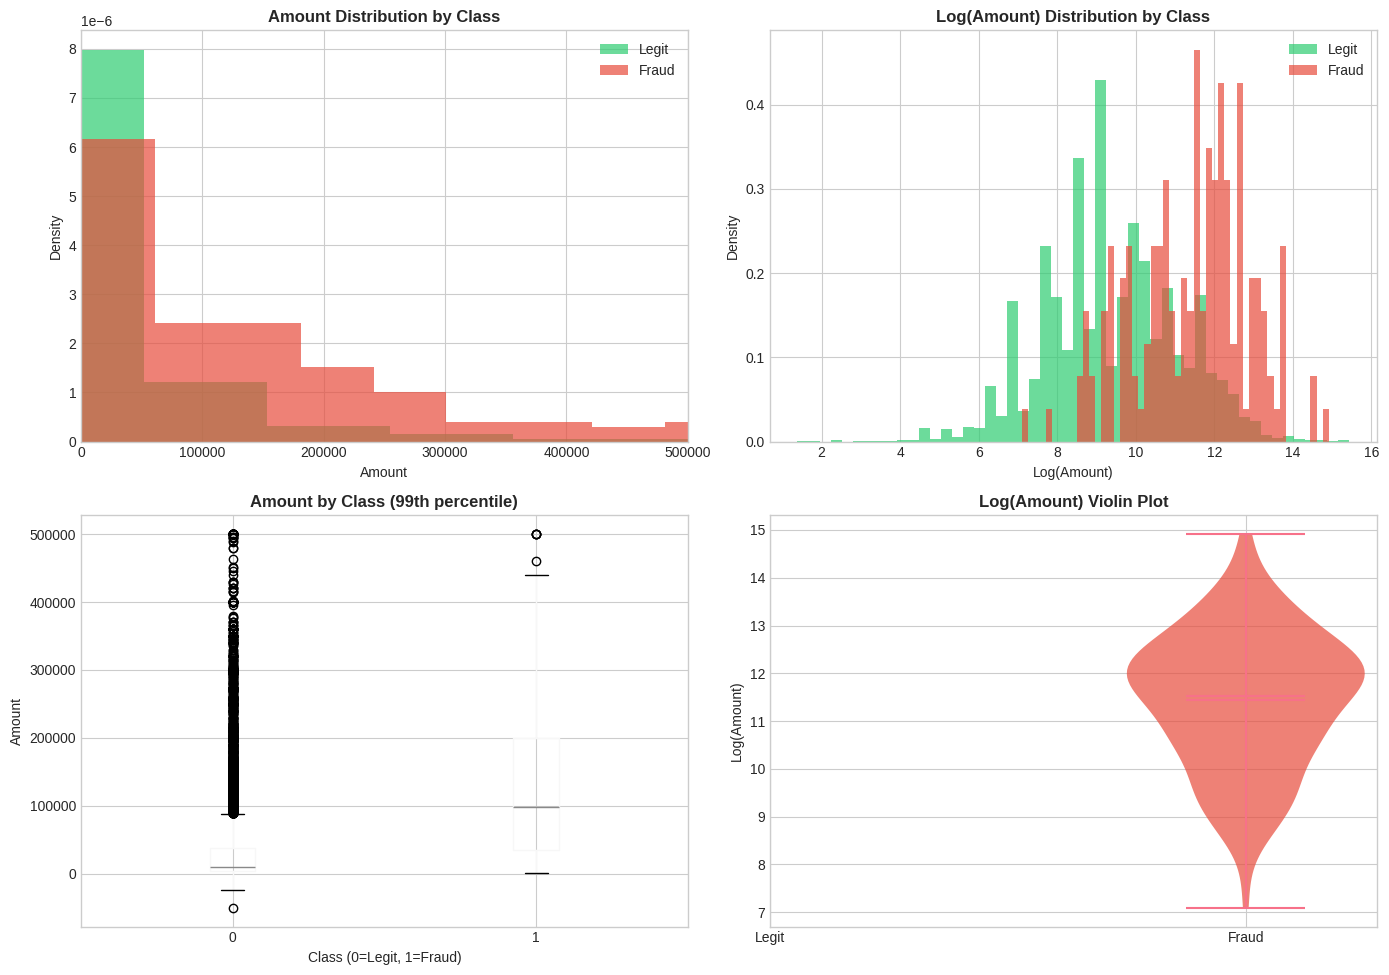


Total Fraud Amount in Dataset: 37,067,154 KZT
Average Fraud Transaction: 224,649 KZT


In [ ]:
print("=" * 60)
print("AMOUNT DISTRIBUTION ANALYSIS")
print("=" * 60)

amount_stats = df.groupby('target')['amount'].agg(['mean', 'median', 'std', 'min', 'max'])
amount_stats.index = ['Legit', 'Fraud']
display(amount_stats)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
df[df['target'] == 0]['amount'].hist(bins=50, ax=ax1, alpha=0.7, color='#2ecc71', label='Legit', density=True)
df[df['target'] == 1]['amount'].hist(bins=50, ax=ax1, alpha=0.7, color='#e74c3c', label='Fraud', density=True)
ax1.set_title('Amount Distribution by Class', fontsize=12, fontweight='bold')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Density')
ax1.legend()
ax1.set_xlim(0, df['amount'].quantile(0.99))

df['log_amount'] = np.log1p(df['amount'])

ax2 = axes[0, 1]
df[df['target'] == 0]['log_amount'].hist(bins=50, ax=ax2, alpha=0.7, color='#2ecc71', label='Legit', density=True)
df[df['target'] == 1]['log_amount'].hist(bins=50, ax=ax2, alpha=0.7, color='#e74c3c', label='Fraud', density=True)
ax2.set_title('Log(Amount) Distribution by Class', fontsize=12, fontweight='bold')
ax2.set_xlabel('Log(Amount)')
ax2.set_ylabel('Density')
ax2.legend()

ax3 = axes[1, 0]
df_plot = df[df['amount'] <= df['amount'].quantile(0.99)]
df_plot.boxplot(column='amount', by='target', ax=ax3)
ax3.set_title('Amount by Class (99th percentile)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Class (0=Legit, 1=Fraud)')
ax3.set_ylabel('Amount')
plt.suptitle('')

ax4 = axes[1, 1]
violin_data = [df[df['target'] == 0]['log_amount'].values, df[df['target'] == 1]['log_amount'].values]
parts = ax4.violinplot(violin_data, positions=[0, 1], showmeans=True, showmedians=True)
colors = ['#2ecc71', '#e74c3c']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
ax4.set_xticks([0, 1])
ax4.set_xticklabels(['Legit', 'Fraud'])
ax4.set_title('Log(Amount) Violin Plot', fontsize=12, fontweight='bold')
ax4.set_ylabel('Log(Amount)')

plt.tight_layout()
plt.show()

fraud_total = df[df['target'] == 1]['amount'].sum()
print(f"\nTotal Fraud Amount in Dataset: {fraud_total:,.0f} KZT")
print(f"Average Fraud Transaction: {df[df['target'] == 1]['amount'].mean():,.0f} KZT")

In [ ]:
print("=" * 60)
print("FEATURE ENGINEERING: ON-THE-FLY FEATURES")
print("=" * 60)

df['hour_of_day'] = df['transdatetime'].dt.hour
df['day_of_week'] = df['transdatetime'].dt.dayofweek
df['day_of_month'] = df['transdatetime'].dt.day
df['is_night'] = ((df['hour_of_day'] >= 0) & (df['hour_of_day'] <= 6)).astype(int)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)

df['log_amount'] = np.log1p(df['amount'])
df['amount_thousands'] = df['amount'] / 1000

print("\nTemporal Features Created:")
print(f"   - hour_of_day: {df['hour_of_day'].min()} - {df['hour_of_day'].max()}")
print(f"   - day_of_week: {df['day_of_week'].min()} - {df['day_of_week'].max()}")
print(f"   - is_night: {df['is_night'].value_counts().to_dict()}")
print(f"   - is_weekend: {df['is_weekend'].value_counts().to_dict()}")

FEATURE ENGINEERING: ON-THE-FLY FEATURES

Temporal Features Created:
   - hour_of_day: 0 - 23
   - day_of_week: 0 - 6
   - is_night: {0: 12580, 1: 560}
   - is_weekend: {0: 9975, 1: 3165}


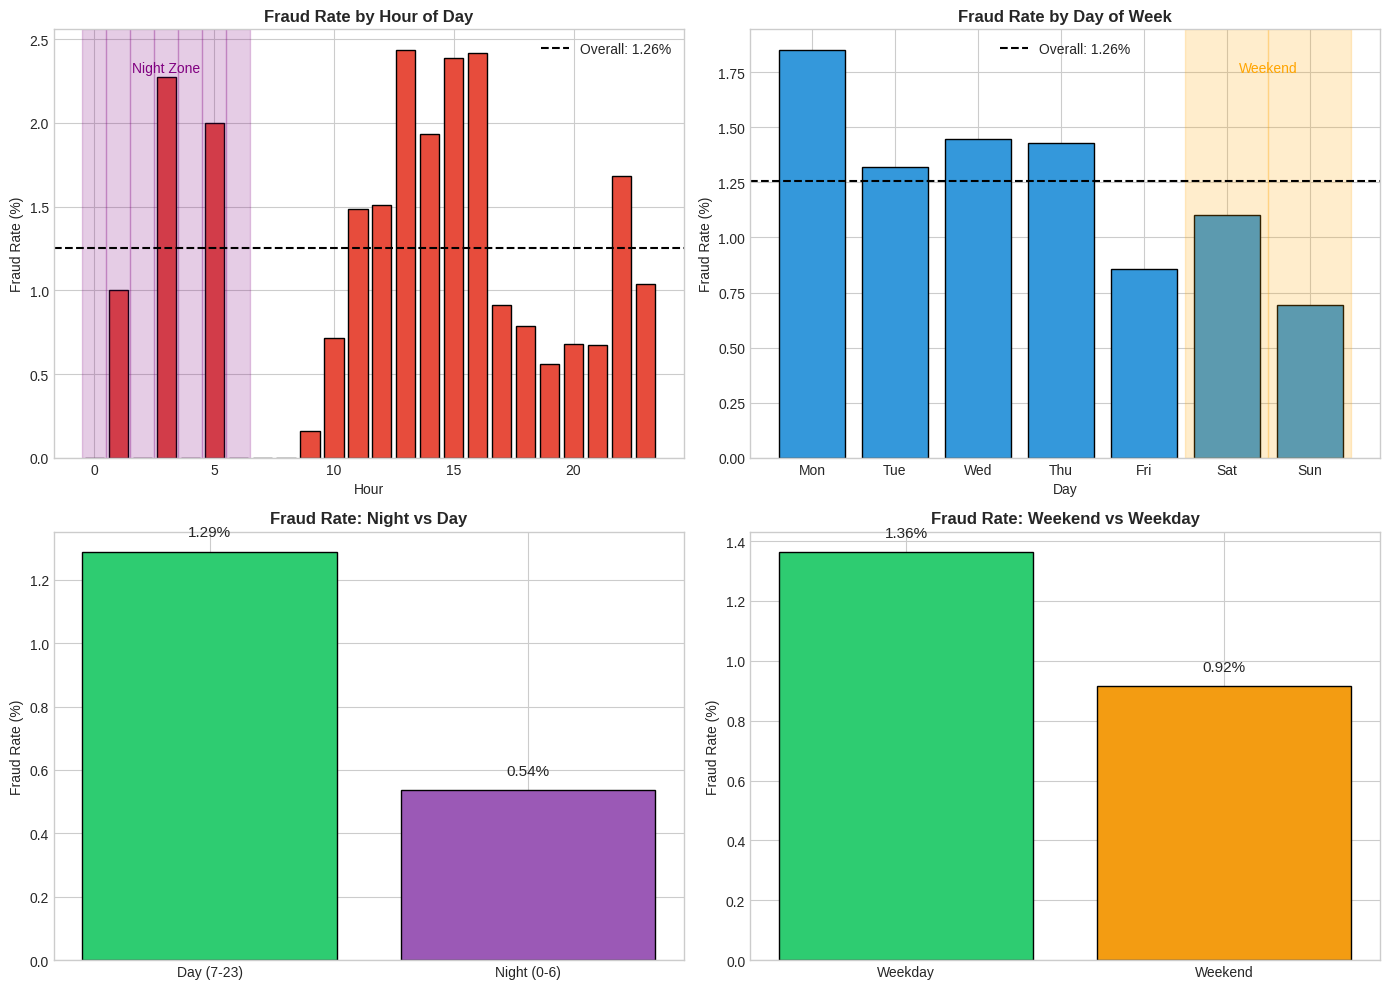


Key Insights:
   - Night fraud rate: 0.54% vs Day: 1.29%
   - Weekend fraud rate: 0.92% vs Weekday: 1.36%


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
hourly_fraud_rate = df.groupby('hour_of_day')['target'].mean() * 100
ax1.bar(hourly_fraud_rate.index, hourly_fraud_rate.values, color='#e74c3c', edgecolor='black')
ax1.axhline(y=df['target'].mean()*100, color='black', linestyle='--', label=f"Overall: {df['target'].mean()*100:.2f}%")
ax1.set_title('Fraud Rate by Hour of Day', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Fraud Rate (%)')
ax1.legend()

for i in range(0, 7):
    ax1.axvspan(i-0.5, i+0.5, alpha=0.2, color='purple')
ax1.text(3, ax1.get_ylim()[1]*0.9, 'Night Zone', ha='center', fontsize=10, color='purple')

ax2 = axes[0, 1]
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_fraud_rate = df.groupby('day_of_week')['target'].mean() * 100
ax2.bar(day_names, daily_fraud_rate.values, color='#3498db', edgecolor='black')
ax2.axhline(y=df['target'].mean()*100, color='black', linestyle='--', label=f"Overall: {df['target'].mean()*100:.2f}%")
ax2.set_title('Fraud Rate by Day of Week', fontsize=12, fontweight='bold')
ax2.set_xlabel('Day')
ax2.set_ylabel('Fraud Rate (%)')
ax2.legend()

for i in [5, 6]:
    ax2.axvspan(i-0.5, i+0.5, alpha=0.2, color='orange')
ax2.text(5.5, ax2.get_ylim()[1]*0.9, 'Weekend', ha='center', fontsize=10, color='orange')

ax3 = axes[1, 0]
night_fraud = df.groupby('is_night')['target'].mean() * 100
ax3.bar(['Day (7-23)', 'Night (0-6)'], night_fraud.values, color=['#2ecc71', '#9b59b6'], edgecolor='black')
ax3.set_title('Fraud Rate: Night vs Day', fontsize=12, fontweight='bold')
ax3.set_ylabel('Fraud Rate (%)')
for i, v in enumerate(night_fraud.values):
    ax3.text(i, v + 0.05, f'{v:.2f}%', ha='center', fontsize=11)

ax4 = axes[1, 1]
weekend_fraud = df.groupby('is_weekend')['target'].mean() * 100
ax4.bar(['Weekday', 'Weekend'], weekend_fraud.values, color=['#2ecc71', '#f39c12'], edgecolor='black')
ax4.set_title('Fraud Rate: Weekend vs Weekday', fontsize=12, fontweight='bold')
ax4.set_ylabel('Fraud Rate (%)')
for i, v in enumerate(weekend_fraud.values):
    ax4.text(i, v + 0.05, f'{v:.2f}%', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"   - Night fraud rate: {night_fraud[1]:.2f}% vs Day: {night_fraud[0]:.2f}%")
print(f"   - Weekend fraud rate: {weekend_fraud[1]:.2f}% vs Weekday: {weekend_fraud[0]:.2f}%")

In [ ]:
print("=" * 60)
print("CATEGORICAL FEATURE PROCESSING")
print("=" * 60)

CATEGORICAL_FEATURES = ['last_phone_model_categorical', 'last_os_categorical', 'direction']

for col in CATEGORICAL_FEATURES:
    if col in df.columns:
        df[col] = df[col].astype(str).fillna('Unknown')
        print(f"\n{col}:")
        print(f"   Unique values: {df[col].nunique()}")
        print(f"   Top 5: {df[col].value_counts().head(5).to_dict()}")

df['os_family'] = df['last_os_categorical'].apply(
    lambda x: 'iOS' if 'iOS' in str(x) else ('Android' if 'Android' in str(x) else 'Unknown')
)

def extract_brand(model):
    model = str(model).lower()
    brands = ['iphone', 'samsung', 'xiaomi', 'huawei', 'oppo', 'vivo', 'realme', 'tecno', 'honor']
    for brand in brands:
        if brand in model:
            return brand.capitalize()
    return 'Other'

df['phone_brand'] = df['last_phone_model_categorical'].apply(extract_brand)

print(f"\nAdditional categorical features created:")
print(f"   - os_family: {df['os_family'].value_counts().to_dict()}")
print(f"   - phone_brand: {df['phone_brand'].value_counts().head(10).to_dict()}")

CATEGORICAL FEATURE PROCESSING

last_phone_model_categorical:
   Unique values: 265
   Top 5: {'iPhone16,1': 984, 'iPhone14,5': 791, 'iPhone14,7': 599, 'iPhone15,4': 531, 'Unknown': 388}

last_os_categorical:
   Unique values: 55
   Top 5: {'Android/14': 2459, 'Android/12': 1234, 'Android/13': 1170, 'Android/15': 1086, 'iOS/18.5': 804}

direction:
   Unique values: 1943
   Top 5: {'0c1de05ea765df1559aabe6d5e076133': 224, '9030efc541153c7eb82a2280c59cda34': 217, '639bd8a0613721b132d1778ea861238c': 200, 'c4ea468194fa3162a9e67d10a761d7bb': 199, '1f1ec07ffa06b3258d49beb4fb3d9f63': 175}

Additional categorical features created:
   - os_family: {'Android': 7194, 'iOS': 5528, 'Unknown': 418}
   - phone_brand: {'Iphone': 5528, 'Xiaomi': 2958, 'Samsung': 1985, 'Vivo': 874, 'Oppo': 718, 'Other': 448, 'Honor': 231, 'Tecno': 174, 'Huawei': 116, 'Realme': 108}


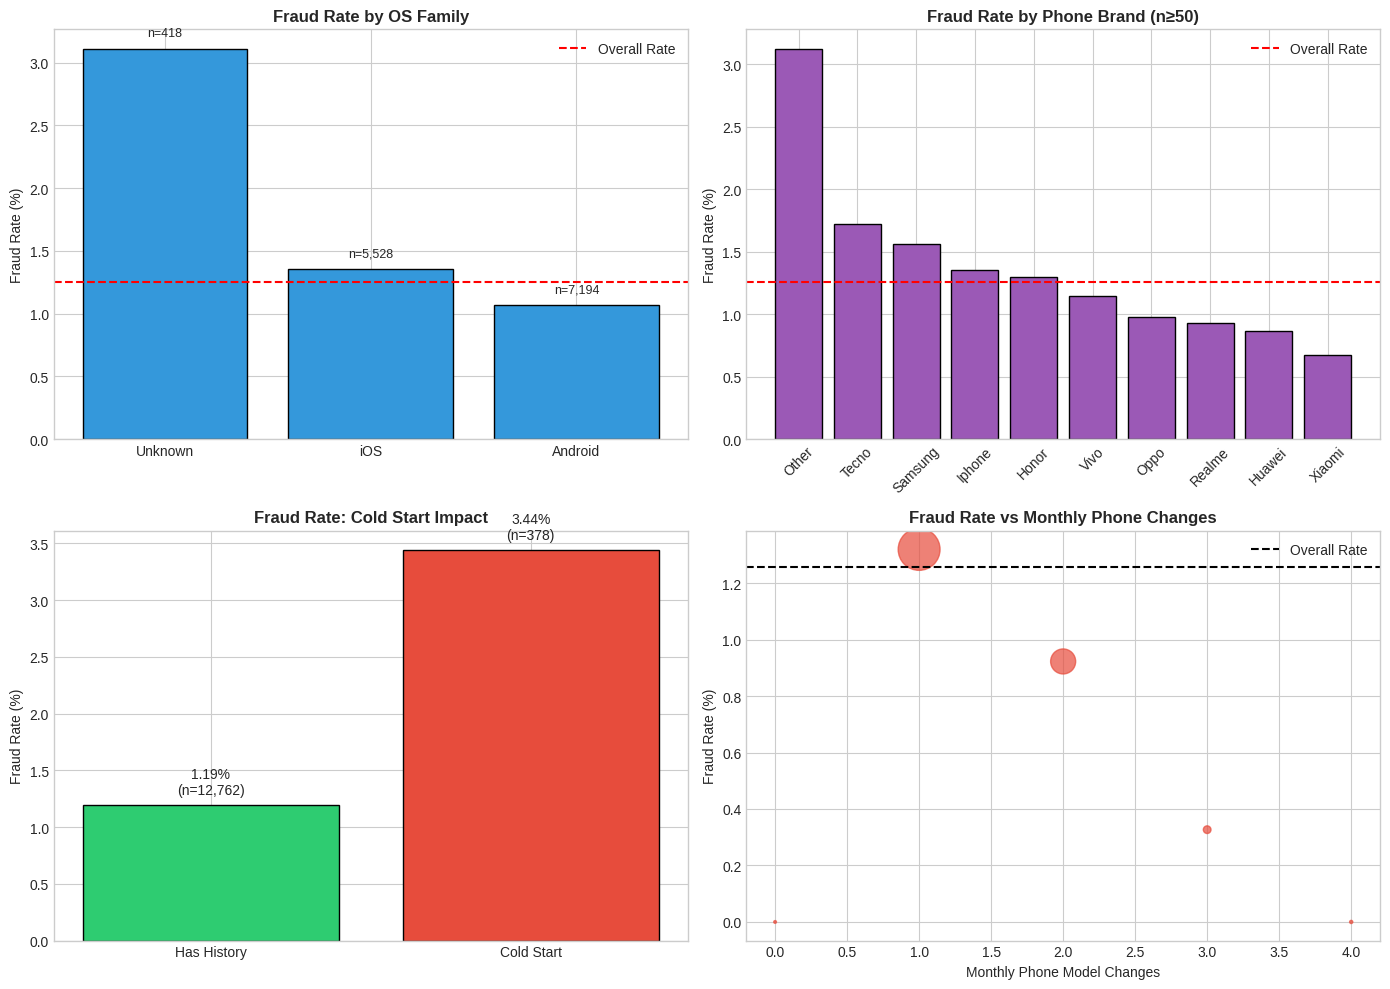

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
os_fraud = df.groupby('os_family').agg({'target': ['sum', 'count']}).droplevel(0, axis=1)
os_fraud['rate'] = os_fraud['sum'] / os_fraud['count'] * 100
os_fraud = os_fraud.sort_values('rate', ascending=False)
bars = ax1.bar(os_fraud.index, os_fraud['rate'], color='#3498db', edgecolor='black')
ax1.axhline(y=df['target'].mean()*100, color='red', linestyle='--', label='Overall Rate')
ax1.set_title('Fraud Rate by OS Family', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fraud Rate (%)')
ax1.legend()
for bar, count in zip(bars, os_fraud['count']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'n={count:,}', ha='center', fontsize=9)

ax2 = axes[0, 1]
brand_fraud = df.groupby('phone_brand').agg({'target': ['sum', 'count']}).droplevel(0, axis=1)
brand_fraud['rate'] = brand_fraud['sum'] / brand_fraud['count'] * 100
brand_fraud = brand_fraud[brand_fraud['count'] >= 50].sort_values('rate', ascending=False).head(10)
bars = ax2.bar(brand_fraud.index, brand_fraud['rate'], color='#9b59b6', edgecolor='black')
ax2.axhline(y=df['target'].mean()*100, color='red', linestyle='--', label='Overall Rate')
ax2.set_title('Fraud Rate by Phone Brand (n≥50)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fraud Rate (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

ax3 = axes[1, 0]
coldstart_fraud = df.groupby('is_cold_start').agg({'target': ['sum', 'count']}).droplevel(0, axis=1)
coldstart_fraud['rate'] = coldstart_fraud['sum'] / coldstart_fraud['count'] * 100
bars = ax3.bar(['Has History', 'Cold Start'], coldstart_fraud['rate'].values,
               color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax3.set_title('Fraud Rate: Cold Start Impact', fontsize=12, fontweight='bold')
ax3.set_ylabel('Fraud Rate (%)')
for bar, (idx, row) in zip(bars, coldstart_fraud.iterrows()):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{row["rate"]:.2f}%\n(n={int(row["count"]):,})', ha='center', fontsize=10)

ax4 = axes[1, 1]
df_no_cold = df[df['is_cold_start'] == 0]
phone_changes = df_no_cold.groupby('monthly_phone_model_changes').agg({'target': ['sum', 'count']}).droplevel(0, axis=1)
phone_changes['rate'] = phone_changes['sum'] / phone_changes['count'] * 100
phone_changes = phone_changes[phone_changes['count'] >= 20]
ax4.scatter(phone_changes.index, phone_changes['rate'], s=phone_changes['count']/10, alpha=0.7, color='#e74c3c')
ax4.axhline(y=df['target'].mean()*100, color='black', linestyle='--', label='Overall Rate')
ax4.set_title('Fraud Rate vs Monthly Phone Changes', fontsize=12, fontweight='bold')
ax4.set_xlabel('Monthly Phone Model Changes')
ax4.set_ylabel('Fraud Rate (%)')
ax4.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("=" * 60)
print("TIME-SERIES SPLIT")
print("=" * 60)

df = df.sort_values('transdatetime').reset_index(drop=True)

FEATURE_COLUMNS = [
    'amount', 'log_amount', 'hour_of_day', 'day_of_week',
    'is_night', 'is_weekend', 'is_month_end', 'is_month_start',
    'monthly_os_changes', 'monthly_phone_model_changes',
    'logins_last_7_days', 'logins_last_30_days',
    'login_frequency_7d', 'login_frequency_30d',
    'freq_change_7d_vs_mean', 'logins_7d_over_30d_ratio',
    'avg_login_interval_30d', 'std_login_interval_30d',
    'ewm_login_interval_7d', 'burstiness_login_interval',
    'zscore_avg_login_interval_7d',
    'is_cold_start'
]

CATEGORICAL_COLS_FOR_MODEL = ['os_family', 'phone_brand', 'direction']

FEATURE_COLUMNS_FULL = FEATURE_COLUMNS + CATEGORICAL_COLS_FOR_MODEL
FEATURE_COLUMNS_FULL = [col for col in FEATURE_COLUMNS_FULL if col in df.columns]

print(f"\nTotal features: {len(FEATURE_COLUMNS_FULL)}")
print(f"   Numerical: {len(FEATURE_COLUMNS)}")
print(f"   Categorical: {len(CATEGORICAL_COLS_FOR_MODEL)}")

SPLIT_RATIO = 0.80
split_idx = int(len(df) * SPLIT_RATIO)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"\nTime-Series Split Results:")
print(f"   Train period: {train_df['transdatetime'].min()} to {train_df['transdatetime'].max()}")
print(f"   Test period:  {test_df['transdatetime'].min()} to {test_df['transdatetime'].max()}")
print(f"   Train size: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"   Test size:  {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")

TIME-SERIES SPLIT

Total features: 25
   Numerical: 22
   Categorical: 3

Time-Series Split Results:
   Train period: 2024-11-30 05:45:05 to 2025-06-25 15:21:43
   Test period:  2025-06-25 15:40:27 to 2025-08-29 22:12:01
   Train size: 10,512 (80.0%)
   Test size:  2,628 (20.0%)


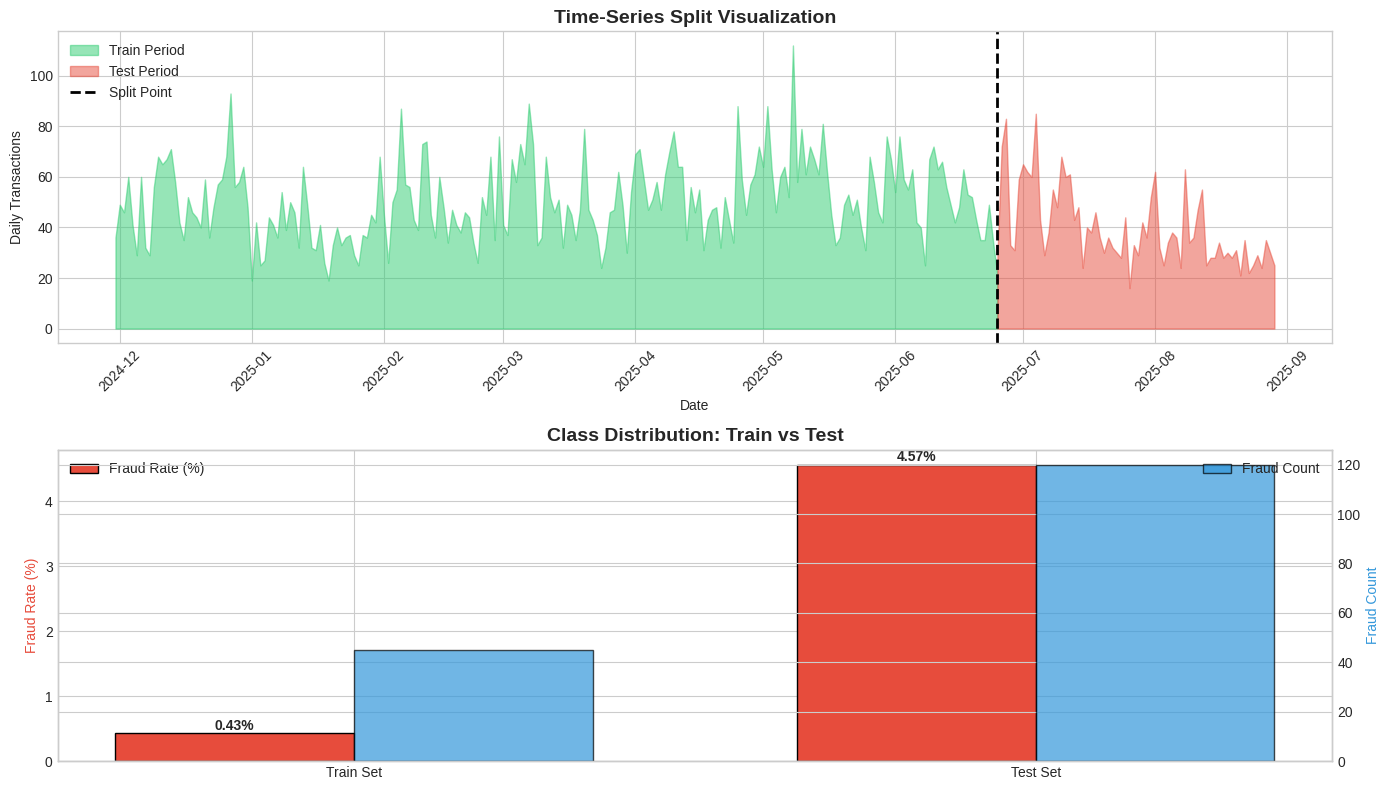


Split Summary:
   Train Fraud: 45 (0.43%)
   Test Fraud:  120 (4.57%)


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

ax1 = axes[0]
train_daily = train_df.groupby(train_df['transdatetime'].dt.date).size()
test_daily = test_df.groupby(test_df['transdatetime'].dt.date).size()

ax1.fill_between(train_daily.index, train_daily.values, alpha=0.5, color='#2ecc71', label='Train Period')
ax1.fill_between(test_daily.index, test_daily.values, alpha=0.5, color='#e74c3c', label='Test Period')
ax1.axvline(x=train_df['transdatetime'].max().date(), color='black', linestyle='--', linewidth=2, label='Split Point')
ax1.set_title('Time-Series Split Visualization', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Transactions')
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=45)

ax2 = axes[1]
train_fraud_rate = train_df['target'].mean() * 100
test_fraud_rate = test_df['target'].mean() * 100
train_fraud_count = train_df['target'].sum()
test_fraud_count = test_df['target'].sum()

x = np.arange(2)
width = 0.35
bars1 = ax2.bar(x - width/2, [train_fraud_rate, test_fraud_rate], width,
                label='Fraud Rate (%)', color='#e74c3c', edgecolor='black')
ax2.set_ylabel('Fraud Rate (%)', color='#e74c3c')
ax2.set_xticks(x)
ax2.set_xticklabels(['Train Set', 'Test Set'])
ax2.legend(loc='upper left')

ax2_twin = ax2.twinx()
bars2 = ax2_twin.bar(x + width/2, [train_fraud_count, test_fraud_count], width,
                     label='Fraud Count', color='#3498db', edgecolor='black', alpha=0.7)
ax2_twin.set_ylabel('Fraud Count', color='#3498db')
ax2_twin.legend(loc='upper right')

ax2.set_title('Class Distribution: Train vs Test', fontsize=14, fontweight='bold')

for bar, rate in zip(bars1, [train_fraud_rate, test_fraud_rate]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{rate:.2f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSplit Summary:")
print(f"   Train Fraud: {train_fraud_count:,} ({train_fraud_rate:.2f}%)")
print(f"   Test Fraud:  {test_fraud_count:,} ({test_fraud_rate:.2f}%)")

In [ ]:
X_train = train_df[FEATURE_COLUMNS_FULL].copy()
y_train = train_df['target'].copy()

X_test = test_df[FEATURE_COLUMNS_FULL].copy()
y_test = test_df['target'].copy()

test_amounts = test_df['amount'].copy()

neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"\nFinal Dataset Shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"\nClass Weights:")
print(f"   Negative (Legit): {neg_count:,}")
print(f"   Positive (Fraud): {pos_count:,}")
print(f"   scale_pos_weight: {scale_pos_weight:.2f}")

cat_feature_indices = [X_train.columns.get_loc(col) for col in CATEGORICAL_COLS_FOR_MODEL if col in X_train.columns]
print(f"\nCategorical feature indices: {cat_feature_indices}")


Final Dataset Shapes:
   X_train: (10512, 25)
   X_test:  (2628, 25)

Class Weights:
   Negative (Legit): 10,467
   Positive (Fraud): 45
   scale_pos_weight: 232.60

Categorical feature indices: [22, 23, 24]


In [ ]:
X_train["freq_change_7d_vs_mean"] = pd.to_numeric(
    X_train["freq_change_7d_vs_mean"], errors="coerce"
)
X_test["freq_change_7d_vs_mean"] = pd.to_numeric(
    X_test["freq_change_7d_vs_mean"], errors="coerce"
)

In [ ]:
X_train["login_frequency_30d"] = pd.to_numeric(
    X_train["login_frequency_30d"], errors="coerce"
)
X_test["login_frequency_30d"] = pd.to_numeric(
    X_test["login_frequency_30d"], errors="coerce"
)

In [ ]:
print("=" * 60)
print("TRAINING CATBOOST CLASSIFIER")
print("=" * 60)

catboost_model = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_seed=RANDOM_STATE,
    verbose=100,
    early_stopping_rounds=50,
    cat_features=cat_feature_indices
)

train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

print("\nTraining CatBoost...")
catboost_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    plot=False
)

print("\nCatBoost training completed!")

TRAINING CATBOOST CLASSIFIER

Training CatBoost...
0:	test: 0.7337204	best: 0.7337204 (0)	total: 13.4ms	remaining: 2m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9393391148
bestIteration = 30

Shrink model to first 31 iterations.

CatBoost training completed!


In [ ]:
catboost_proba = catboost_model.predict_proba(X_test)[:, 1]
catboost_pred = (catboost_proba >= 0.5).astype(int)

catboost_roc_auc = roc_auc_score(y_test, catboost_proba)
catboost_pr_auc = average_precision_score(y_test, catboost_proba)

print(f"\nCatBoost Performance on Test Set:")
print(f"   ROC-AUC: {catboost_roc_auc:.4f}")
print(f"   PR-AUC:  {catboost_pr_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, catboost_pred, target_names=['Legit', 'Fraud']))


CatBoost Performance on Test Set:
   ROC-AUC: 0.9393
   PR-AUC:  0.3887

Classification Report:
              precision    recall  f1-score   support

       Legit       0.99      0.91      0.95      2508
       Fraud       0.29      0.78      0.42       120

    accuracy                           0.90      2628
   macro avg       0.64      0.85      0.69      2628
weighted avg       0.96      0.90      0.92      2628



In [ ]:
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

label_encoders = {}
for col in CATEGORICAL_COLS_FOR_MODEL:
    if col in X_train_xgb.columns:
        le = LabelEncoder()
        combined = pd.concat([X_train_xgb[col], X_test_xgb[col]], axis=0).astype(str)
        le.fit(combined)
        X_train_xgb[col] = le.transform(X_train_xgb[col].astype(str))
        X_test_xgb[col] = le.transform(X_test_xgb[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique values")

xgboost_model = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=12,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=RANDOM_STATE,
    early_stopping_rounds=50,
    verbosity=1
)

print("\nTraining XGBoost...")
xgboost_model.fit(
    X_train_xgb, y_train,
    eval_set=[(X_test_xgb, y_test)],
    verbose=100
)

print("\nXGBoost training completed!")

Encoded os_family: 3 unique values
Encoded phone_brand: 10 unique values
Encoded direction: 1943 unique values

Training XGBoost...
[0]	validation_0-auc:0.70848
[50]	validation_0-auc:0.62140

XGBoost training completed!


In [ ]:
xgboost_proba = xgboost_model.predict_proba(X_test_xgb)[:, 1]
xgboost_pred = (xgboost_proba >= 0.5).astype(int)

xgboost_roc_auc = roc_auc_score(y_test, xgboost_proba)
xgboost_pr_auc = average_precision_score(y_test, xgboost_proba)

print(f"\nXGBoost Performance on Test Set:")
print(f"   ROC-AUC: {xgboost_roc_auc:.4f}")
print(f"   PR-AUC:  {xgboost_pr_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, xgboost_pred, target_names=['Legit', 'Fraud']))


XGBoost Performance on Test Set:
   ROC-AUC: 0.7085
   PR-AUC:  0.1241

Classification Report:
              precision    recall  f1-score   support

       Legit       0.96      0.94      0.95      2508
       Fraud       0.17      0.23      0.19       120

    accuracy                           0.91      2628
   macro avg       0.56      0.59      0.57      2628
weighted avg       0.93      0.91      0.92      2628



MODEL COMPARISON: TECHNICAL METRICS


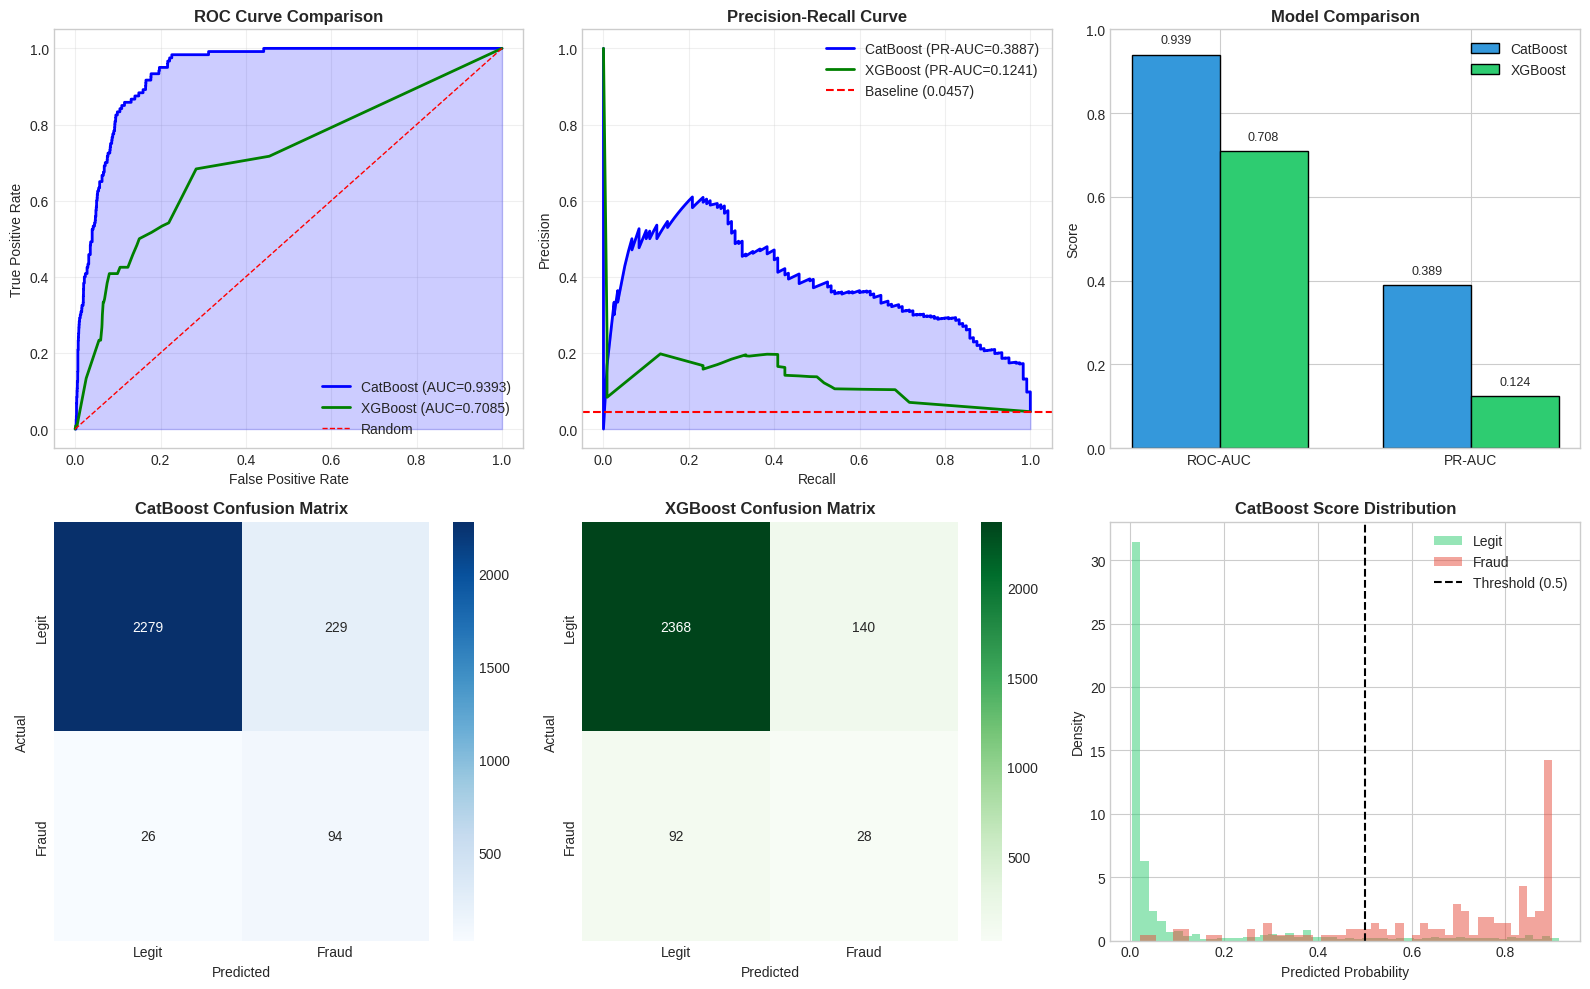

In [ ]:
print("=" * 60)
print("MODEL COMPARISON: TECHNICAL METRICS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

ax1 = axes[0, 0]
fpr_cat, tpr_cat, _ = roc_curve(y_test, catboost_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgboost_proba)

ax1.plot(fpr_cat, tpr_cat, 'b-', linewidth=2, label=f'CatBoost (AUC={catboost_roc_auc:.4f})')
ax1.plot(fpr_xgb, tpr_xgb, 'g-', linewidth=2, label=f'XGBoost (AUC={xgboost_roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
ax1.fill_between(fpr_cat, tpr_cat, alpha=0.2, color='blue')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Comparison', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
precision_cat, recall_cat, _ = precision_recall_curve(y_test, catboost_proba)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgboost_proba)

ax2.plot(recall_cat, precision_cat, 'b-', linewidth=2, label=f'CatBoost (PR-AUC={catboost_pr_auc:.4f})')
ax2.plot(recall_xgb, precision_xgb, 'g-', linewidth=2, label=f'XGBoost (PR-AUC={xgboost_pr_auc:.4f})')
ax2.axhline(y=y_test.mean(), color='r', linestyle='--', label=f'Baseline ({y_test.mean():.4f})')
ax2.fill_between(recall_cat, precision_cat, alpha=0.2, color='blue')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

ax3 = axes[0, 2]
metrics = ['ROC-AUC', 'PR-AUC']
catboost_scores = [catboost_roc_auc, catboost_pr_auc]
xgboost_scores = [xgboost_roc_auc, xgboost_pr_auc]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax3.bar(x - width/2, catboost_scores, width, label='CatBoost', color='#3498db', edgecolor='black')
bars2 = ax3.bar(x + width/2, xgboost_scores, width, label='XGBoost', color='#2ecc71', edgecolor='black')
ax3.set_ylabel('Score')
ax3.set_title('Model Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.set_ylim(0, 1)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax4 = axes[1, 0]
cm_cat = confusion_matrix(y_test, catboost_pred)
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')
ax4.set_title('CatBoost Confusion Matrix', fontsize=12, fontweight='bold')

ax5 = axes[1, 1]
cm_xgb = confusion_matrix(y_test, xgboost_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=ax5,
            xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
ax5.set_xlabel('Predicted')
ax5.set_ylabel('Actual')
ax5.set_title('XGBoost Confusion Matrix', fontsize=12, fontweight='bold')

ax6 = axes[1, 2]
ax6.hist(catboost_proba[y_test == 0], bins=50, alpha=0.5, label='Legit', color='#2ecc71', density=True)
ax6.hist(catboost_proba[y_test == 1], bins=50, alpha=0.5, label='Fraud', color='#e74c3c', density=True)
ax6.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Density')
ax6.set_title('CatBoost Score Distribution', fontsize=12, fontweight='bold')
ax6.legend()

plt.tight_layout()
plt.show()

In [ ]:
def calculate_metrics_at_threshold(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'Threshold': threshold,
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn
    }

catboost_metrics = calculate_metrics_at_threshold(y_test, catboost_proba, 0.5)
xgboost_metrics = calculate_metrics_at_threshold(y_test, xgboost_proba, 0.5)

comparison_df = pd.DataFrame({
    'Metric': ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1-Score',
               'True Positives', 'False Positives', 'True Negatives', 'False Negatives'],
    'CatBoost': [catboost_roc_auc, catboost_pr_auc,
                 catboost_metrics['Precision'], catboost_metrics['Recall'], catboost_metrics['F1-Score'],
                 catboost_metrics['True Positives'], catboost_metrics['False Positives'],
                 catboost_metrics['True Negatives'], catboost_metrics['False Negatives']],
    'XGBoost': [xgboost_roc_auc, xgboost_pr_auc,
                xgboost_metrics['Precision'], xgboost_metrics['Recall'], xgboost_metrics['F1-Score'],
                xgboost_metrics['True Positives'], xgboost_metrics['False Positives'],
                xgboost_metrics['True Negatives'], xgboost_metrics['False Negatives']]
})

comparison_df['Winner'] = comparison_df.apply(
    lambda row: 'CatBoost' if row['CatBoost'] > row['XGBoost'] else ('XGBoost' if row['XGBoost'] > row['CatBoost'] else 'Tie'),
    axis=1
)

print("\nMODEL COMPARISON TABLE (Threshold = 0.5):")
display(comparison_df)

best_model_name = 'CatBoost' if catboost_roc_auc >= xgboost_roc_auc else 'XGBoost'
best_model = catboost_model if best_model_name == 'CatBoost' else xgboost_model
best_proba = catboost_proba if best_model_name == 'CatBoost' else xgboost_proba

print(f"\nBest Model: {best_model_name} (based on ROC-AUC)")


MODEL COMPARISON TABLE (Threshold = 0.5):


,Metric,CatBoost,XGBoost,Winner
0,ROC-AUC,0.9393,0.7085,CatBoost
1,PR-AUC,0.3887,0.1241,CatBoost
2,Precision,0.2910,0.1667,CatBoost
3,Recall,0.7833,0.2333,CatBoost
4,F1-Score,0.4244,0.1944,CatBoost
5,True Positives,94.0000,28.0000,CatBoost
6,False Positives,229.0000,140.0000,CatBoost
7,True Negatives,2279.0000,2368.0000,XGBoost
8,False Negatives,26.0000,92.0000,XGBoost



Best Model: CatBoost (based on ROC-AUC)


In [ ]:
def calculate_business_metrics(y_true, y_proba, amounts, threshold=0.5, cost_per_fp=5000):
    y_pred = (y_proba >= threshold).astype(int)
    tp_mask = (y_true == 1) & (y_pred == 1)
    fp_mask = (y_true == 0) & (y_pred == 1)
    fn_mask = (y_true == 1) & (y_pred == 0)

    money_saved = amounts[tp_mask].sum()
    money_lost = amounts[fn_mask].sum()
    fp_cost = fp_mask.sum() * cost_per_fp
    net_benefit = money_saved - fp_cost

    total_fraud_amount = amounts[y_true == 1].sum()
    detection_rate = money_saved / total_fraud_amount if total_fraud_amount > 0 else 0

    return {
        'threshold': threshold,
        'money_saved': money_saved,
        'money_lost': money_lost,
        'fp_cost': fp_cost,
        'net_benefit': net_benefit,
        'detection_rate': detection_rate,
        'frauds_caught': tp_mask.sum(),
        'frauds_missed': fn_mask.sum(),
        'false_alarms': fp_mask.sum()
    }

COST_PER_FP = 5000

catboost_business = calculate_business_metrics(y_test.values, catboost_proba, test_amounts.values, threshold=0.5, cost_per_fp=COST_PER_FP)
xgboost_business = calculate_business_metrics(y_test.values, xgboost_proba, test_amounts.values, threshold=0.5, cost_per_fp=COST_PER_FP)

print(f"{'Metric':<25} {'CatBoost':>12} {'XGBoost':>12}")
print("="*50)
print(f"{'Money Saved (KZT)':<25} {catboost_business['money_saved']:>12,.0f} {xgboost_business['money_saved']:>12,.0f}")
print(f"{'Money Lost (KZT)':<25} {catboost_business['money_lost']:>12,.0f} {xgboost_business['money_lost']:>12,.0f}")
print(f"{'FP Investigation Cost':<25} {catboost_business['fp_cost']:>12,.0f} {xgboost_business['fp_cost']:>12,.0f}")
print(f"{'Net Benefit (KZT)':<25} {catboost_business['net_benefit']:>12,.0f} {xgboost_business['net_benefit']:>12,.0f}")
print(f"{'Detection Rate':<25} {catboost_business['detection_rate']:>11.1%} {xgboost_business['detection_rate']:>11.1%}")
print(f"{'Frauds Caught':<25} {catboost_business['frauds_caught']:>12} {xgboost_business['frauds_caught']:>12}")
print(f"{'Frauds Missed':<25} {catboost_business['frauds_missed']:>12} {xgboost_business['frauds_missed']:>12}")
print(f"{'False Alarms':<25} {catboost_business['false_alarms']:>12} {xgboost_business['false_alarms']:>12}")

Metric                        CatBoost      XGBoost
Money Saved (KZT)           18,473,577   10,206,541
Money Lost (KZT)               843,805    9,110,841
FP Investigation Cost        1,145,000      700,000
Net Benefit (KZT)           17,328,577    9,506,541
Detection Rate                  95.6%       52.8%
Frauds Caught                       94           28
Frauds Missed                       26           92
False Alarms                       229          140


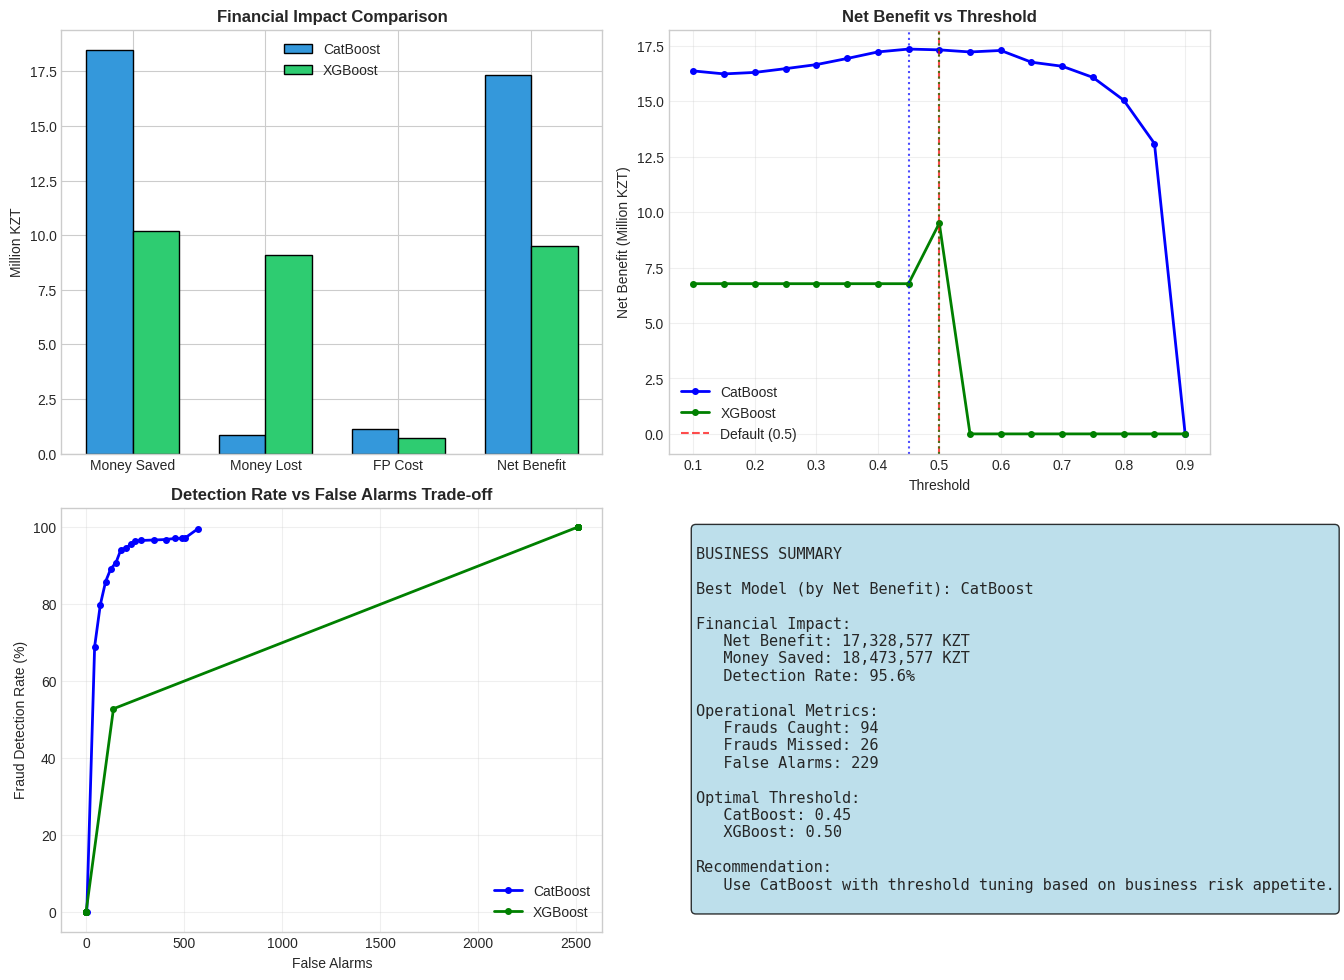

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
metrics_names = ['Money Saved', 'Money Lost', 'FP Cost', 'Net Benefit']
catboost_values = [catboost_business['money_saved']/1e6, catboost_business['money_lost']/1e6,
                   catboost_business['fp_cost']/1e6, catboost_business['net_benefit']/1e6]
xgboost_values = [xgboost_business['money_saved']/1e6, xgboost_business['money_lost']/1e6,
                  xgboost_business['fp_cost']/1e6, xgboost_business['net_benefit']/1e6]

x = np.arange(len(metrics_names))
width = 0.35
ax1.bar(x - width/2, catboost_values, width, label='CatBoost', color='#3498db', edgecolor='black')
ax1.bar(x + width/2, xgboost_values, width, label='XGBoost', color='#2ecc71', edgecolor='black')
ax1.set_ylabel('Million KZT')
ax1.set_title('Financial Impact Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names)
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax2 = axes[0, 1]
thresholds = np.arange(0.1, 0.95, 0.05)
catboost_net_benefits = []
xgboost_net_benefits = []

for thresh in thresholds:
    cat_biz = calculate_business_metrics(y_test.values, catboost_proba, test_amounts.values, thresh, COST_PER_FP)
    xgb_biz = calculate_business_metrics(y_test.values, xgboost_proba, test_amounts.values, thresh, COST_PER_FP)
    catboost_net_benefits.append(cat_biz['net_benefit']/1e6)
    xgboost_net_benefits.append(xgb_biz['net_benefit']/1e6)

ax2.plot(thresholds, catboost_net_benefits, 'b-o', linewidth=2, markersize=4, label='CatBoost')
ax2.plot(thresholds, xgboost_net_benefits, 'g-o', linewidth=2, markersize=4, label='XGBoost')
ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Net Benefit (Million KZT)')
ax2.set_title('Net Benefit vs Threshold', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

optimal_thresh_cat = thresholds[np.argmax(catboost_net_benefits)]
optimal_thresh_xgb = thresholds[np.argmax(xgboost_net_benefits)]
ax2.axvline(x=optimal_thresh_cat, color='blue', linestyle=':', alpha=0.7)
ax2.axvline(x=optimal_thresh_xgb, color='green', linestyle=':', alpha=0.7)

ax3 = axes[1, 0]
catboost_detection = []
catboost_false_alarms = []
xgboost_detection = []
xgboost_false_alarms = []

for thresh in thresholds:
    cat_biz = calculate_business_metrics(y_test.values, catboost_proba, test_amounts.values, thresh, COST_PER_FP)
    xgb_biz = calculate_business_metrics(y_test.values, xgboost_proba, test_amounts.values, thresh, COST_PER_FP)
    catboost_detection.append(cat_biz['detection_rate']*100)
    catboost_false_alarms.append(cat_biz['false_alarms'])
    xgboost_detection.append(xgb_biz['detection_rate']*100)
    xgboost_false_alarms.append(xgb_biz['false_alarms'])

ax3.plot(catboost_false_alarms, catboost_detection, 'b-o', linewidth=2, markersize=4, label='CatBoost')
ax3.plot(xgboost_false_alarms, xgboost_detection, 'g-o', linewidth=2, markersize=4, label='XGBoost')
ax3.set_xlabel('False Alarms')
ax3.set_ylabel('Fraud Detection Rate (%)')
ax3.set_title('Detection Rate vs False Alarms Trade-off', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.axis('off')

winner = 'CatBoost' if catboost_business['net_benefit'] > xgboost_business['net_benefit'] else 'XGBoost'
winner_benefit = max(catboost_business['net_benefit'], xgboost_business['net_benefit'])

summary_text = f"""
BUSINESS SUMMARY

Best Model (by Net Benefit): {winner}

Financial Impact:
   Net Benefit: {winner_benefit:,.0f} KZT
   Money Saved: {catboost_business['money_saved']:,.0f} KZT
   Detection Rate: {catboost_business['detection_rate']:.1%}

Operational Metrics:
   Frauds Caught: {catboost_business['frauds_caught']}
   Frauds Missed: {catboost_business['frauds_missed']}
   False Alarms: {catboost_business['false_alarms']}

Optimal Threshold:
   CatBoost: {optimal_thresh_cat:.2f}
   XGBoost: {optimal_thresh_xgb:.2f}

Recommendation:
   Use {winner} with threshold tuning based on business risk appetite.
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
print("=" * 60)
print("SHAP ANALYSIS FOR MODEL INTERPRETABILITY")
print("=" * 60)

print("\nComputing SHAP values for CatBoost (this may take a moment)...")

explainer = shap.TreeExplainer(catboost_model)

sample_size = min(1000, len(X_test))
X_test_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(X_test_sample)

print(f"SHAP values computed for {sample_size} samples")

feature_names = X_test.columns.tolist()

SHAP ANALYSIS FOR MODEL INTERPRETABILITY

Computing SHAP values for CatBoost (this may take a moment)...
SHAP values computed for 1000 samples



GLOBAL FEATURE IMPORTANCE (SHAP Summary)


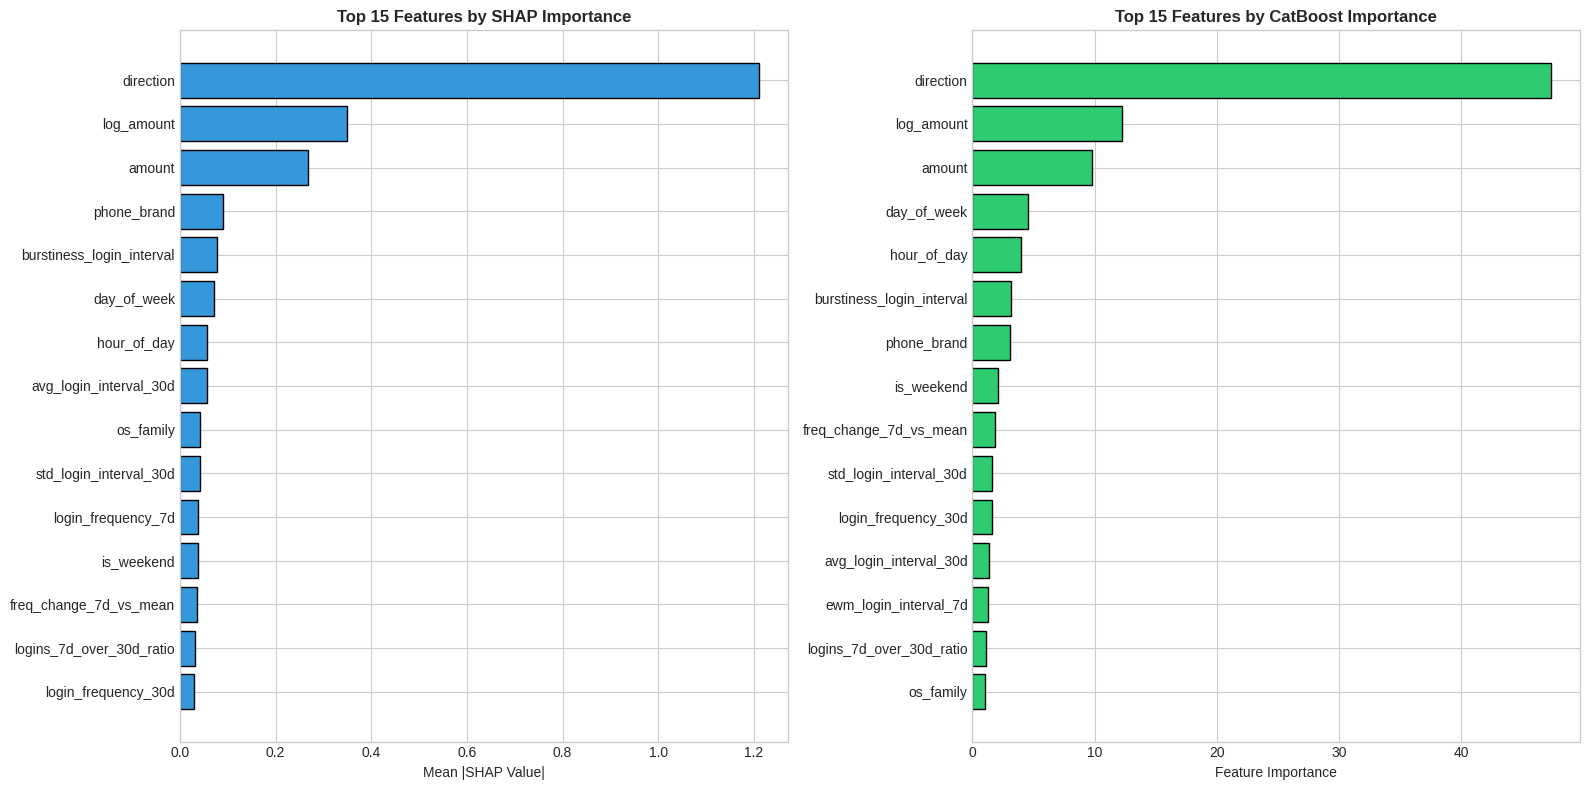

In [ ]:
print("\nGLOBAL FEATURE IMPORTANCE (SHAP Summary)")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

ax1 = axes[0]
shap_importance = np.abs(shap_values).mean(axis=0)
sorted_idx = np.argsort(shap_importance)[-15:]
ax1.barh(range(len(sorted_idx)), shap_importance[sorted_idx], color='#3498db', edgecolor='black')
ax1.set_yticks(range(len(sorted_idx)))
ax1.set_yticklabels([feature_names[i] for i in sorted_idx])
ax1.set_xlabel('Mean |SHAP Value|')
ax1.set_title('Top 15 Features by SHAP Importance', fontsize=12, fontweight='bold')

ax2 = axes[1]
catboost_importance = catboost_model.get_feature_importance()
sorted_idx_cat = np.argsort(catboost_importance)[-15:]
ax2.barh(range(len(sorted_idx_cat)), catboost_importance[sorted_idx_cat], color='#2ecc71', edgecolor='black')
ax2.set_yticks(range(len(sorted_idx_cat)))
ax2.set_yticklabels([feature_names[i] for i in sorted_idx_cat])
ax2.set_xlabel('Feature Importance')
ax2.set_title('Top 15 Features by CatBoost Importance', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


SHAP Beeswarm Plot (Feature Impact Direction)


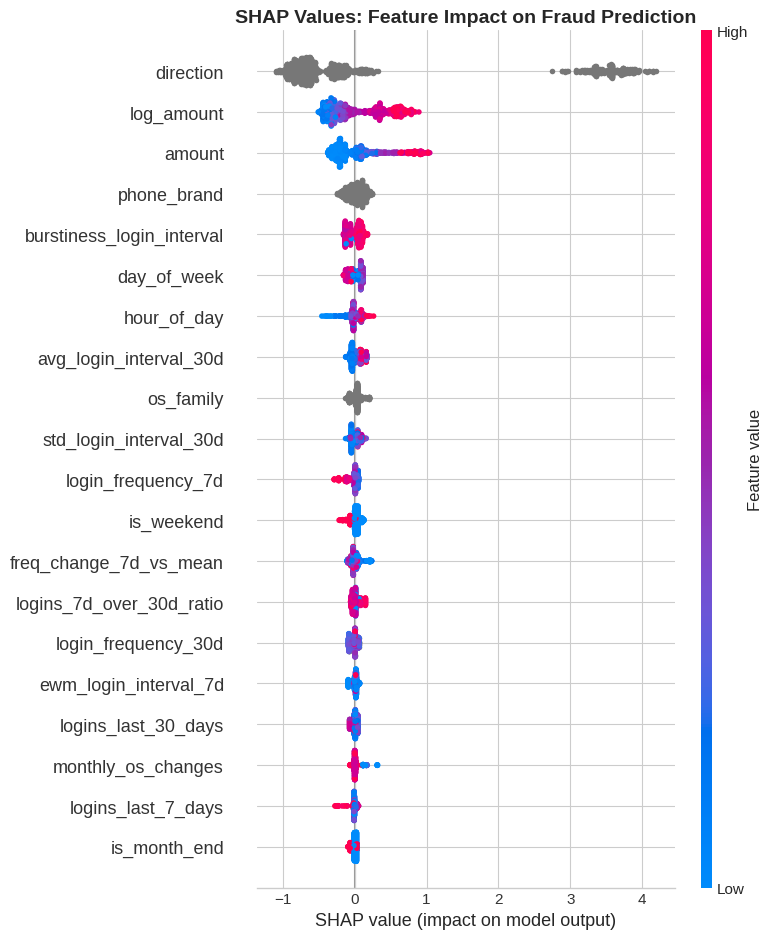


How to read this plot:
   • Each dot = one transaction
   • Red = high feature value, Blue = low feature value
   • Right of center = increases fraud probability
   • Left of center = decreases fraud probability


In [ ]:
print("\nSHAP Beeswarm Plot (Feature Impact Direction)")

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names,
                  plot_type="dot", max_display=20, show=False)
plt.title('SHAP Values: Feature Impact on Fraud Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHow to read this plot:")
print("   • Each dot = one transaction")
print("   • Red = high feature value, Blue = low feature value")
print("   • Right of center = increases fraud probability")
print("   • Left of center = decreases fraud probability")

In [ ]:
print("\nLOCAL EXPLANATION: High-Risk Transaction Analysis")

high_risk_frauds = test_df[
    (catboost_proba >= 0.7) & (y_test == 1)
].index[:3]

if len(high_risk_frauds) > 0:
    print(f"\nAnalyzing {len(high_risk_frauds)} high-confidence fraud detections:")

    for i, idx in enumerate(high_risk_frauds):
        pos = test_df.index.get_loc(idx) if idx in test_df.index else i
        if pos < len(X_test_sample):
            print(f"\n{'='*60}")
            print(f"FRAUD CASE #{i+1}")
            print(f"{'='*60}")

            trans = test_df.loc[idx]
            print(f"   Amount: {trans['amount']:,.0f} KZT")
            print(f"   Time: {trans['transdatetime']}")
            print(f"   Fraud Probability: {catboost_proba[pos]:.2%}")

            case_shap = shap_values[pos]

            factor_importance = list(zip(feature_names, case_shap))
            factor_importance.sort(key=lambda x: abs(x[1]), reverse=True)

            print(f"\n   Top Risk Factors:")
            for feat, shap_val in factor_importance[:5]:
                direction = "↑ INCREASES" if shap_val > 0 else "↓ DECREASES"
                print(f"      • {feat}: {direction} risk by {abs(shap_val):.3f}")
else:
    print("   No high-confidence fraud detections found in sample")


LOCAL EXPLANATION: High-Risk Transaction Analysis

Analyzing 3 high-confidence fraud detections:

FRAUD CASE #1
   Amount: 40,000 KZT
   Time: 2025-06-26 15:15:28
   Fraud Probability: 76.66%

   Top Risk Factors:
      • direction: ↑ INCREASES risk by 3.864
      • log_amount: ↑ INCREASES risk by 0.351
      • amount: ↑ INCREASES risk by 0.226
      • hour_of_day: ↑ INCREASES risk by 0.136
      • is_weekend: ↑ INCREASES risk by 0.099

FRAUD CASE #2
   Amount: 220,000 KZT
   Time: 2025-06-26 17:11:42
   Fraud Probability: 88.87%

   Top Risk Factors:
      • direction: ↑ INCREASES risk by 3.804
      • amount: ↑ INCREASES risk by 0.938
      • log_amount: ↑ INCREASES risk by 0.641
      • hour_of_day: ↑ INCREASES risk by 0.136
      • is_weekend: ↑ INCREASES risk by 0.115

FRAUD CASE #3
   Amount: 175,000 KZT
   Time: 2025-06-27 12:05:13
   Fraud Probability: 84.58%

   Top Risk Factors:
      • direction: ↑ INCREASES risk by 3.644
      • amount: ↑ INCREASES risk by 0.935
      • lo


SHAP Waterfall Plot: Detailed Explanation of a Single Fraud Case


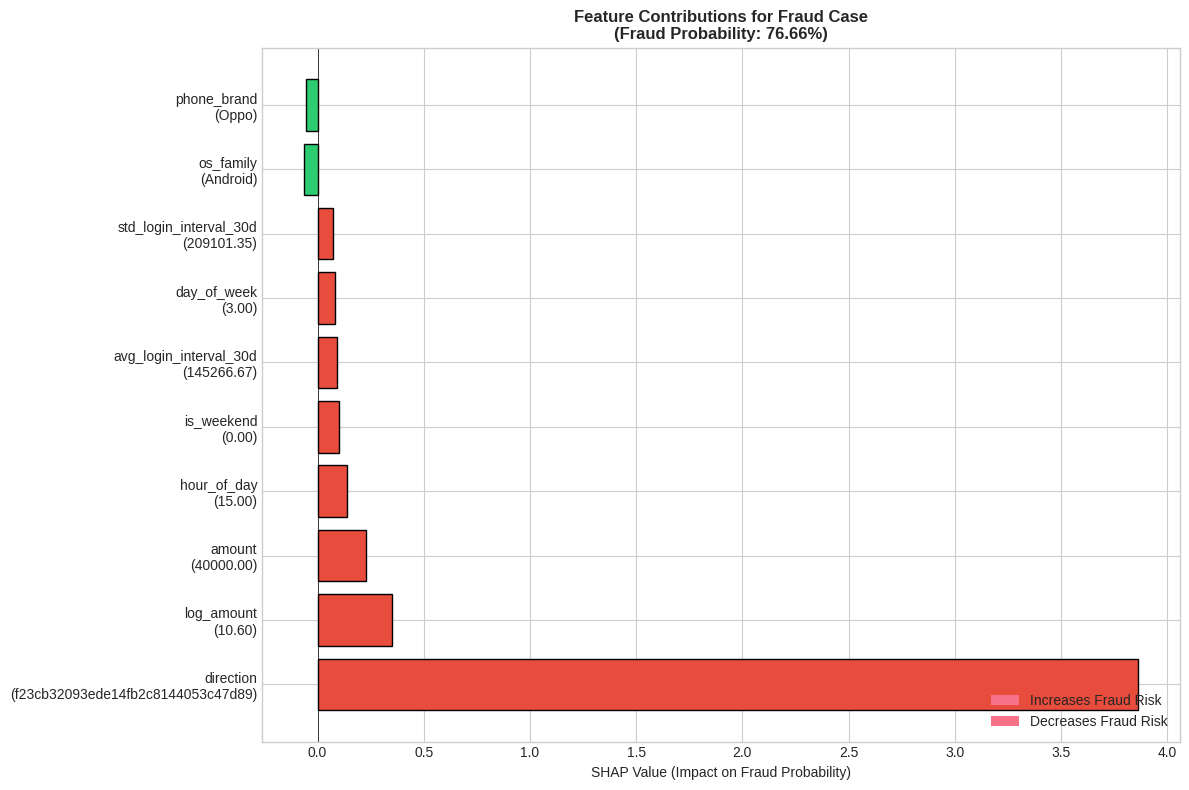


This transaction was flagged as FRAUD with 76.66% confidence
Base rate: -3.6771 → Final score: 0.7666


In [ ]:
print("\nSHAP Waterfall Plot: Detailed Explanation of a Single Fraud Case")

tp_indices = np.where((y_test.iloc[:sample_size] == 1) & (catboost_proba[:sample_size] >= 0.5))[0]

if len(tp_indices) > 0:
    case_idx = tp_indices[0]

    fig, ax = plt.subplots(figsize=(12, 8))

    base_value = explainer.expected_value
    case_shap = shap_values[case_idx]

    sorted_idx = np.argsort(np.abs(case_shap))[::-1][:10]

    colors = ['#e74c3c' if case_shap[i] > 0 else '#2ecc71' for i in sorted_idx]
    y_pos = np.arange(len(sorted_idx))

    # Helper function to format values based on their type
    def format_display_value(value):
        if isinstance(value, (int, float, np.number)):
            return f"{value:.2f}"
        else:
            return str(value)

    ax.barh(y_pos, [case_shap[i] for i in sorted_idx], color=colors, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"""{feature_names[i]}\n({format_display_value(X_test_sample.iloc[case_idx, i])})""" for i in sorted_idx])
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('SHAP Value (Impact on Fraud Probability)')
    ax.set_title(f'Feature Contributions for Fraud Case\n(Fraud Probability: {catboost_proba[case_idx]:.2%})',
                 fontsize=12, fontweight='bold')

    ax.barh([], [], color='#e74c3c', label='Increases Fraud Risk')
    ax.barh([], [], color='#2ecc71', label='Decreases Fraud Risk')
    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    print(f"\nThis transaction was flagged as FRAUD with {catboost_proba[case_idx]:.2%} confidence")
    print(f"Base rate: {base_value:.4f} → Final score: {catboost_proba[case_idx]:.4f}")
else:
    print("No true positive cases found in sample for detailed analysis")

In [ ]:
print("=" * 60)
print("THRESHOLD TUNING: BUSINESS TRADE-OFF ANALYSIS")
print("=" * 60)

thresholds = np.arange(0.05, 0.96, 0.05)
threshold_analysis = []

for thresh in thresholds:
    y_pred = (catboost_proba >= thresh).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    biz = calculate_business_metrics(y_test.values, catboost_proba, test_amounts.values, thresh, COST_PER_FP)

    threshold_analysis.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Fraud_Caught': tp,
        'Fraud_Missed': fn,
        'False_Alarms': fp,
        'Net_Benefit': biz['net_benefit'],
        'Detection_Rate': biz['detection_rate']
    })

threshold_df = pd.DataFrame(threshold_analysis)

print("\nThreshold Analysis Table:")
display(threshold_df.round(4))

THRESHOLD TUNING: BUSINESS TRADE-OFF ANALYSIS

Threshold Analysis Table:


,Threshold,Precision,Recall,F1,Fraud_Caught,Fraud_Missed,False_Alarms,Net_Benefit,Detection_Rate
0,0.0500,0.1406,0.9833,0.2461,118,2,721,15622382.0000,0.9953
1,0.1000,0.1715,0.9833,0.2921,118,2,570,16377382.0000,0.9953
2,0.1500,0.1842,0.9500,0.3085,114,6,505,16243057.0000,0.9716
3,0.2000,0.1870,0.9333,0.3115,112,8,487,16311057.0000,0.9704
4,0.2500,0.1982,0.9333,0.3270,112,8,453,16481057.0000,0.9704
5,0.3000,0.2086,0.8917,0.3381,107,13,406,16662577.0000,0.9677
6,0.3500,0.2311,0.8667,0.3649,104,16,346,16938777.0000,0.9664
7,0.4000,0.2656,0.8500,0.4048,102,18,282,17234777.0000,0.9652
8,0.4500,0.2857,0.8333,0.4255,100,20,250,17363577.0000,0.9636
9,0.5000,0.2910,0.7833,0.4244,94,26,229,17328577.0000,0.9563


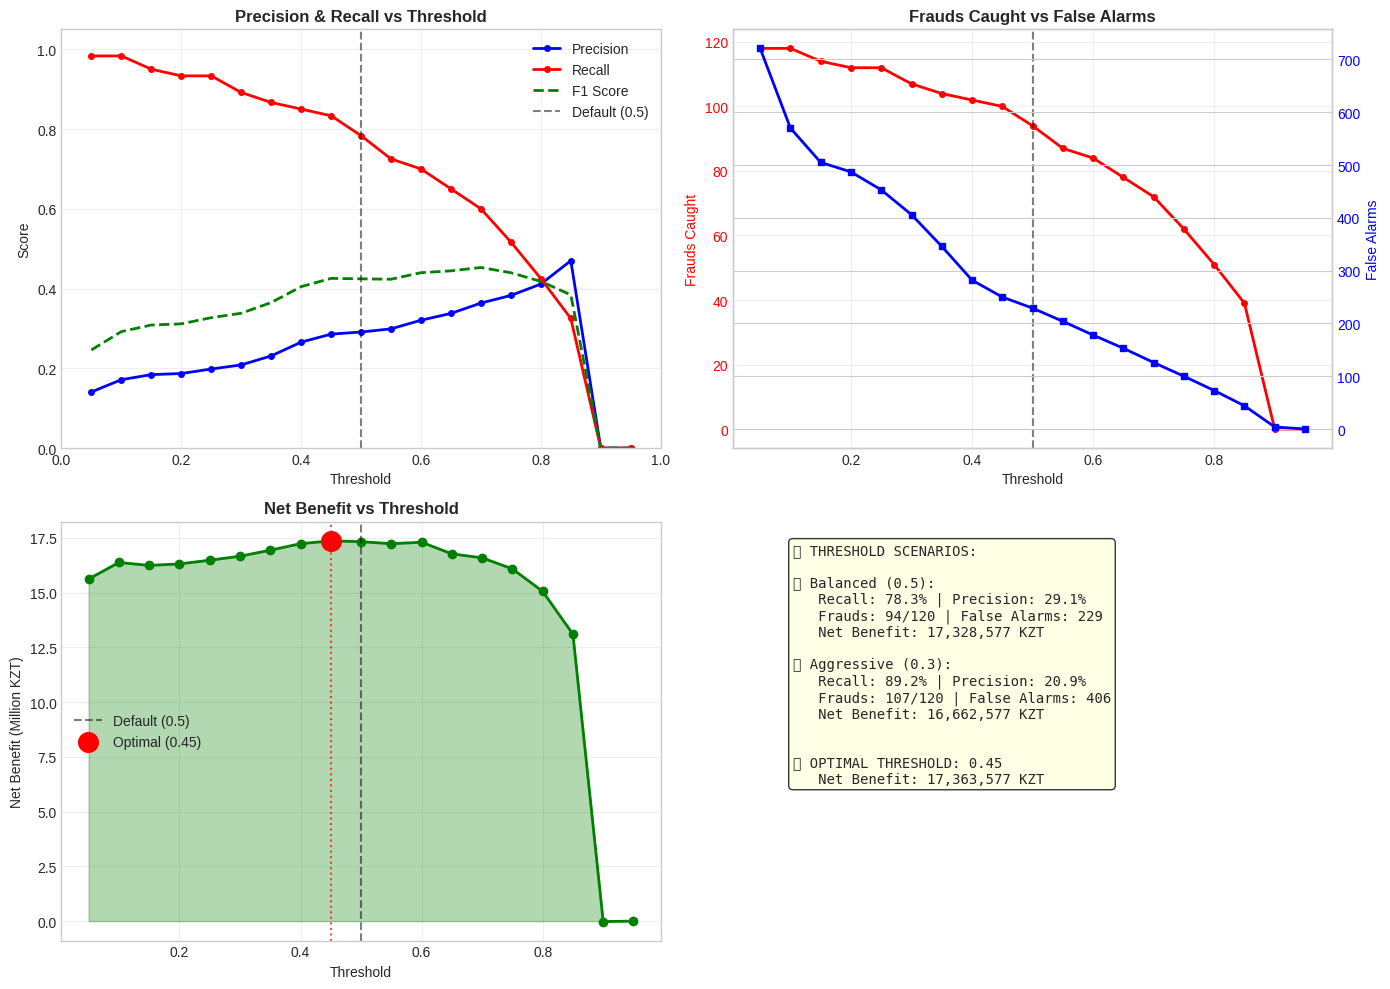

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
ax1.plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-o', linewidth=2, markersize=4, label='Precision')
ax1.plot(threshold_df['Threshold'], threshold_df['Recall'], 'r-o', linewidth=2, markersize=4, label='Recall')
ax1.plot(threshold_df['Threshold'], threshold_df['F1'], 'g--', linewidth=2, label='F1 Score')
ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default (0.5)')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision & Recall vs Threshold', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1.05)

ax2 = axes[0, 1]
ax2.plot(threshold_df['Threshold'], threshold_df['Fraud_Caught'], 'r-o', linewidth=2, markersize=4, label='Frauds Caught')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Frauds Caught', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2_twin = ax2.twinx()
ax2_twin.plot(threshold_df['Threshold'], threshold_df['False_Alarms'], 'b-s', linewidth=2, markersize=4, label='False Alarms')
ax2_twin.set_ylabel('False Alarms', color='blue')
ax2_twin.tick_params(axis='y', labelcolor='blue')
ax2.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('Frauds Caught vs False Alarms', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
ax3.plot(threshold_df['Threshold'], threshold_df['Net_Benefit'] / 1e6, 'g-o', linewidth=2, markersize=6)
ax3.fill_between(threshold_df['Threshold'], threshold_df['Net_Benefit'] / 1e6, alpha=0.3, color='green')
ax3.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default (0.5)')
optimal_idx = threshold_df['Net_Benefit'].idxmax()
optimal_thresh = threshold_df.loc[optimal_idx, 'Threshold']
optimal_benefit = threshold_df.loc[optimal_idx, 'Net_Benefit'] / 1e6
ax3.scatter([optimal_thresh], [optimal_benefit], color='red', s=200, zorder=5, label=f'Optimal ({optimal_thresh:.2f})')
ax3.axvline(x=optimal_thresh, color='red', linestyle=':', alpha=0.7)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Net Benefit (Million KZT)')
ax3.set_title('Net Benefit vs Threshold', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.axis('off')
scenarios = [('Conservative (0.7)', 0.7, '#2ecc71'), ('Balanced (0.5)', 0.5, '#3498db'), ('Aggressive (0.3)', 0.3, '#e74c3c')]
scenario_text = "📊 THRESHOLD SCENARIOS:\n\n"
for name, thresh, _ in scenarios:
    row = threshold_df[threshold_df['Threshold'] == thresh].iloc[0] if thresh in threshold_df['Threshold'].values else None
    if row is not None:
        scenario_text += f"🔹 {name}:\n"
        scenario_text += f"   Recall: {row['Recall']:.1%} | Precision: {row['Precision']:.1%}\n"
        scenario_text += f"   Frauds: {int(row['Fraud_Caught'])}/{int(row['Fraud_Caught']+row['Fraud_Missed'])} | False Alarms: {int(row['False_Alarms'])}\n"
        scenario_text += f"   Net Benefit: {row['Net_Benefit']:,.0f} KZT\n\n"
scenario_text += f"\n🏆 OPTIMAL THRESHOLD: {optimal_thresh:.2f}\n"
scenario_text += f"   Net Benefit: {optimal_benefit*1e6:,.0f} KZT"
ax4.text(0.1, 0.95, scenario_text, transform=ax4.transAxes, fontsize=10, verticalalignment='top',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
print("=" * 70)
print("FRAUD DETECTION ML PIPELINE - FINAL SUMMARY")
print("=" * 70)

final_metrics = calculate_business_metrics(
    y_test.values, catboost_proba, test_amounts.values,
    threshold=optimal_thresh, cost_per_fp=COST_PER_FP
)

print(f"""
BEST MODEL: CatBoost Classifier

TECHNICAL METRICS (Test Set):
   • ROC-AUC Score:    {catboost_roc_auc:.4f}
   • PR-AUC Score:     {catboost_pr_auc:.4f}
   • Optimal Threshold: {optimal_thresh:.2f}

BUSINESS IMPACT (at optimal threshold):
   • Money Saved:      {final_metrics['money_saved']:>12,.0f} KZT
   • Money Lost:       {final_metrics['money_lost']:>12,.0f} KZT
   • Net Benefit:      {final_metrics['net_benefit']:>12,.0f} KZT
   • Detection Rate:   {final_metrics['detection_rate']:>11.1%}

OPERATIONAL METRICS:
   • Frauds Caught:    {final_metrics['frauds_caught']:>5} / {final_metrics['frauds_caught'] + final_metrics['frauds_missed']}
   • Frauds Missed:    {final_metrics['frauds_missed']:>5}
   • False Alarms:     {final_metrics['false_alarms']:>5}

MODEL SPECIFICATIONS:
   • Algorithm:        CatBoost Classifier
   • Features:         {len(FEATURE_COLUMNS_FULL)}
   • Training Samples: {len(X_train):,}
   • Test Samples:     {len(X_test):,}
   • Class Weights:    Balanced (auto)

KEY FILES:
   • Transactions:     транзакции в Мобильном интернет Банкинге.csv
   • Patterns:         поведенческие паттерны клиентов.csv
""")

FRAUD DETECTION ML PIPELINE - FINAL SUMMARY

BEST MODEL: CatBoost Classifier

TECHNICAL METRICS (Test Set):
   • ROC-AUC Score:    0.9393
   • PR-AUC Score:     0.3887
   • Optimal Threshold: 0.45

BUSINESS IMPACT (at optimal threshold):
   • Money Saved:        18,613,577 KZT
   • Money Lost:            703,805 KZT
   • Net Benefit:        17,363,577 KZT
   • Detection Rate:         96.4%

OPERATIONAL METRICS:
   • Frauds Caught:      100 / 120
   • Frauds Missed:       20
   • False Alarms:       250

MODEL SPECIFICATIONS:
   • Algorithm:        CatBoost Classifier
   • Features:         25
   • Training Samples: 10,512
   • Test Samples:     2,628
   • Class Weights:    Balanced (auto)

KEY FILES:
   • Transactions:     транзакции в Мобильном интернет Банкинге.csv
   • Patterns:         поведенческие паттерны клиентов.csv



In [ ]:
MODEL_PATH = "fraud_detection_catboost.cbm"
catboost_model.save_model(MODEL_PATH)
print(f"Model saved to: {MODEL_PATH}")

import json
from datetime import datetime

model_config = {
    'model_type': 'CatBoost',
    'model_file': MODEL_PATH,
    'optimal_threshold': float(optimal_thresh),
    'feature_columns': FEATURE_COLUMNS_FULL,
    'categorical_features': CATEGORICAL_COLS_FOR_MODEL,
    'numerical_features': FEATURE_COLUMNS,
    'roc_auc': float(catboost_roc_auc),
    'pr_auc': float(catboost_pr_auc),
    'training_date': str(datetime.now()),
    'cold_start_value': -1
}

CONFIG_PATH = "model_config.json"
with open(CONFIG_PATH, 'w', encoding='utf-8') as f:
    json.dump(model_config, f, indent=2, ensure_ascii=False)

print(f"Config saved to: {CONFIG_PATH}")

Model saved to: fraud_detection_catboost.cbm
Config saved to: model_config.json


FRAUD DETECTION MODEL - PERFORMANCE DASHBOARD


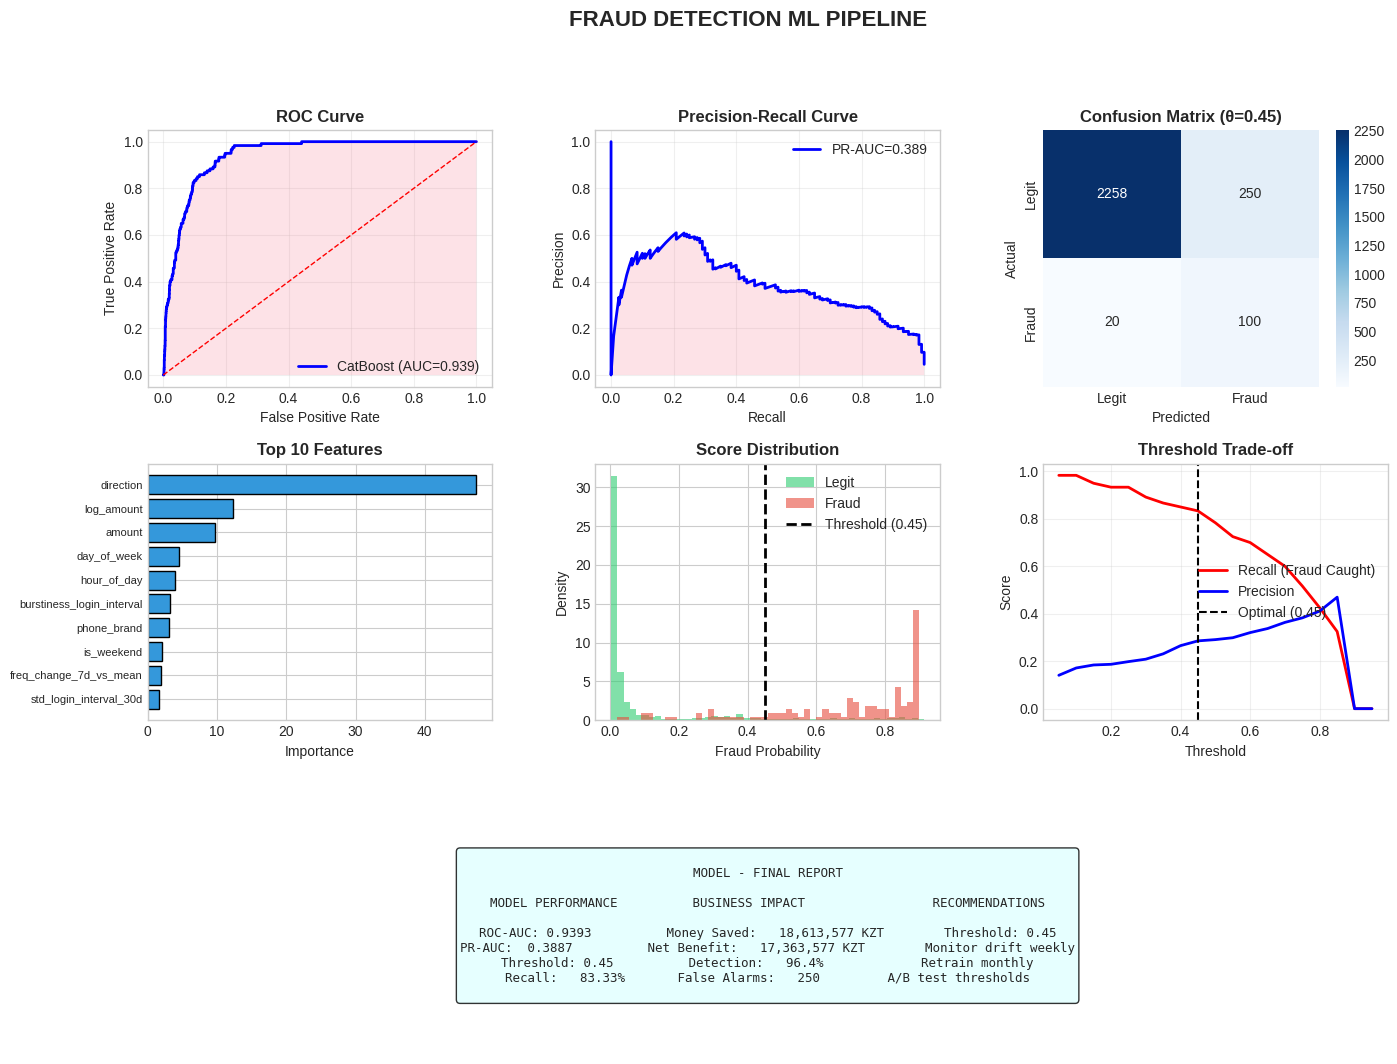

Dashboard saved to: fraud_detection_dashboard.png
PIPELINE COMPLETE! Ready for production deployment.


In [ ]:
print("=" * 70)
print("FRAUD DETECTION MODEL - PERFORMANCE DASHBOARD")
print("=" * 70)

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ROC Curve
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(fpr_cat, tpr_cat, 'b-', linewidth=2, label=f'CatBoost (AUC={catboost_roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'r--', linewidth=1)
ax1.fill_between(fpr_cat, tpr_cat, alpha=0.2)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(recall_cat, precision_cat, 'b-', linewidth=2, label=f'PR-AUC={catboost_pr_auc:.3f}')
ax2.fill_between(recall_cat, precision_cat, alpha=0.2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Confusion Matrix
ax3 = fig.add_subplot(gs[0, 2])
y_pred_optimal = (catboost_proba >= optimal_thresh).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_title(f'Confusion Matrix (θ={optimal_thresh:.2f})', fontweight='bold')

# Feature Importance (Top 10)
ax4 = fig.add_subplot(gs[1, 0])
importance = catboost_model.get_feature_importance()
top_idx = np.argsort(importance)[-10:]
ax4.barh(range(len(top_idx)), importance[top_idx], color='#3498db', edgecolor='black')
ax4.set_yticks(range(len(top_idx)))
ax4.set_yticklabels([FEATURE_COLUMNS_FULL[i] for i in top_idx], fontsize=8)
ax4.set_xlabel('Importance')
ax4.set_title('Top 10 Features', fontweight='bold')

# Score Distribution
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(catboost_proba[y_test == 0], bins=50, alpha=0.6, color='#2ecc71', label='Legit', density=True)
ax5.hist(catboost_proba[y_test == 1], bins=50, alpha=0.6, color='#e74c3c', label='Fraud', density=True)
ax5.axvline(x=optimal_thresh, color='black', linestyle='--', linewidth=2, label=f'Threshold ({optimal_thresh:.2f})')
ax5.set_xlabel('Fraud Probability')
ax5.set_ylabel('Density')
ax5.set_title('Score Distribution', fontweight='bold')
ax5.legend()

# Threshold Trade-off
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(threshold_df['Threshold'], threshold_df['Recall'], 'r-', linewidth=2, label='Recall (Fraud Caught)')
ax6.plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-', linewidth=2, label='Precision')
ax6.axvline(x=optimal_thresh, color='black', linestyle='--', label=f'Optimal ({optimal_thresh:.2f})')
ax6.set_xlabel('Threshold')
ax6.set_ylabel('Score')
ax6.set_title('Threshold Trade-off', fontweight='bold')
ax6.legend(loc='center right')
ax6.grid(True, alpha=0.3)

# Summary Panel
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

summary = f"""
MODEL - FINAL REPORT

MODEL PERFORMANCE          BUSINESS IMPACT                 RECOMMENDATIONS

ROC-AUC: {catboost_roc_auc:.4f}          Money Saved: {final_metrics['money_saved']:>12,.0f} KZT        Threshold: {optimal_thresh:.2f}
PR-AUC:  {catboost_pr_auc:.4f}          Net Benefit: {final_metrics['net_benefit']:>12,.0f} KZT        Monitor drift weekly
Threshold: {optimal_thresh:.2f}          Detection:   {final_metrics['detection_rate']:.1%}             Retrain monthly
Recall:   {threshold_df[threshold_df['Threshold']==optimal_thresh]['Recall'].values[0] if optimal_thresh in threshold_df['Threshold'].values else 0:.2%}       False Alarms: {final_metrics['false_alarms']:>5}         A/B test thresholds
"""

ax7.text(0.5, 0.5, summary, transform=ax7.transAxes, fontsize=9,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

plt.suptitle('FRAUD DETECTION ML PIPELINE', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('fraud_detection_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("Dashboard saved to: fraud_detection_dashboard.png")
print("PIPELINE COMPLETE! Ready for production deployment.")